## Build MRCNN Model -Load MRCNN and FCN weights - Load Training Files  

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os, pprint, pickle
pp = pprint.PrettyPrinter(indent=2, width=100)
print('Current working dir: ', os.getcwd())
if '..' not in sys.path:
    print("appending '..' to sys.path")
    sys.path.append('..')
import copy    
import numpy as np
import matplotlib.pyplot as plt
from matplotlib          import cm
import mrcnn.utils       as utils
import mrcnn.visualize   as visualize
import mrcnn.visualize  as vis
import mrcnn.visualize_2 as vis2
from mrcnn.prep_notebook import build_fcn_inference_pipeline_newshapes, build_fcn_evaluate_pipeline_newshapes
from mrcnn.prep_notebook import get_inference_batch, get_evaluate_batch, get_image_batch
from mrcnn.prep_notebook import run_mrcnn_detection, run_fcn_detection, run_fcn_evaluation
from mrcnn.newshapes     import prep_newshape_dataset
from mrcnn.visualize     import display_training_batch
# from mrcnn.utils         import trim_zeros, compute_overlaps
# from mrcnn.calculate_map import update_map_dictionaries

# WEIGHT_FILE = 'F:/models/train_fcn8_coco_adam/fcn20181109T0000/fcn_2298.h5' 
# FCN_WEIGHT_FILE = 'F:\\models_newshapes\\train_fcn8_l2_newshapes\\fcn20181224T0000\\fcn_0821.h5'
##------------------------------------------------------------------------------------
## Parse command line arguments
##------------------------------------------------------------------------------------
parser = utils.command_line_parser()
input_parms  =" --batch_size     1  "
input_parms +=" --dataset        newshapes2 "
input_parms +=" --mrcnn_logs_dir train_mrcnn "
input_parms +=" --fcn_logs_dir   train_fcn8L2_BCE1 " 
input_parms +=" --mrcnn_model    /home/kbardool/models_newshapes2/train_mrcnn/mrcnn20190318T0000/"+ "mrcnn_0020.h5 "
input_parms +=" --fcn_model      /home/kbardool/models_newshapes2/train_fcn8L2_BCE/fcn20190323T0000/" + "fcn_0089.h5"
input_parms +=" --fcn_arch       fcn8l2 " 
input_parms +=" --sysout         screen "
input_parms +=" --evaluate_method 3"
input_parms +=" --scale_factor    1"
args = parser.parse_args(input_parms.split())
utils.display_input_parms(args)

CLASS_COLUMN        = 4
ORIG_SCORE_COLUMN   = 5
DT_TYPE_COLUMN      = 6
SEQUENCE_COLUMN     = 7
NORM_SCORE_COLUMN   = 8    
SCORE_0_SUM_COLUMN  = 9
SCORE_0_AREA_COLUMN = 10
SCORE_0_COLUMN      = 11
SCORE_1_SUM_COLUMN  = 12
SCORE_1_AREA_COLUMN = 13
SCORE_1_COLUMN      = 14 
SCORE_1_NORM_COLUMN = 17
SCORE_2_SUM_COLUMN  = 18
SCORE_2_AREA_COLUMN = 19
SCORE_2_COLUMN      = 20
SCORE_2_NORM_COLUMN = 23

Current working dir:  /home/kbardool/git_projs/mrcnn3/notebooks
appending '..' to sys.path


Using TensorFlow backend.


 Init Image Class - Possible Object Choices:  {'airplane': 3, 'person': 5, 'sun': 1, 'building': 3, 'car': 3, 'cloud': 3, 'truck': 3, 'tree': 5}
 Init Image Class - Custom Color Keys      :  ['person', 'sky', 'sun', 'cloud', 'ground', 'tree']
 Init Image Class - Object Priority List   :  ['building', 'tree', 'car']
 Init Image Class - BUILD_MAX_TRIES        :  7
 Init Image Class - PERSON_CAR_DISTANCE    :  10

   Arguments passed :
   --------------------
   batch_size                     1
   coco_classes                   None
   dataset                        newshapes2
   epochs                         1
   evaluate_method                3
   fcn_arch                       FCN8L2
   fcn_bce_loss_class             0
   fcn_bce_loss_method            1
   fcn_layers                     ['fcn32+']
   fcn_logs_dir                   train_fcn8L2_BCE1
   fcn_losses                     fcn_BCE_loss
   fcn_model                      /home/kbardool/models_newshapes2/train_fcn8L2_BCE/fcn201

## Load test dataset

In [9]:
# with open(os.path.join(mrcnn_model.config.DIR_DATASET,"newshapes2_test_dataset_1000_A.pkl"), 'rb') as infile:
with open(os.path.join("/home/kbardool/MLDatasets/newshapes2","newshapes2_test_dataset_1000_A.pkl"), 'rb') as infile:
    dataset_test = pickle.load(infile)
print(type(dataset_test))    

dataset_test.display_active_class_info()
print("Testing Dataset Image Count: {}".format(len(dataset_test.image_ids)))
print("Testing Dataset Class Count: {}".format(dataset_test.num_classes))
print(len(dataset_test.image_ids))    
class_names = dataset_test.class_names

<class 'mrcnn.newshapes2.NewImagesDataset'>
 Active Class Information 
--------------------------
[1, 2, 3, 4, 5, 6, 7, 8]
internal_class:  1 ext_cls: 1 category-name: None - person
internal_class:  2 ext_cls: 2 category-name: None - car
internal_class:  3 ext_cls: 3 category-name: None - sun
internal_class:  4 ext_cls: 4 category-name: None - building
internal_class:  5 ext_cls: 5 category-name: None - tree
internal_class:  6 ext_cls: 6 category-name: None - cloud
internal_class:  7 ext_cls: 7 category-name: None - airplane
internal_class:  8 ext_cls: 8 category-name: None - truck
Testing Dataset Image Count: 1000
Testing Dataset Class Count: 9
1000


###  Display some images from dataset

In [4]:
# image_list = list(range(160,200))
image_list = list(range(132, 132))
image_titles = [str(i) for i in image_list]
images = get_image_batch(dataset_test, image_list)
visualize.display_images(images, titles = image_titles, cols = 8, width = 24)

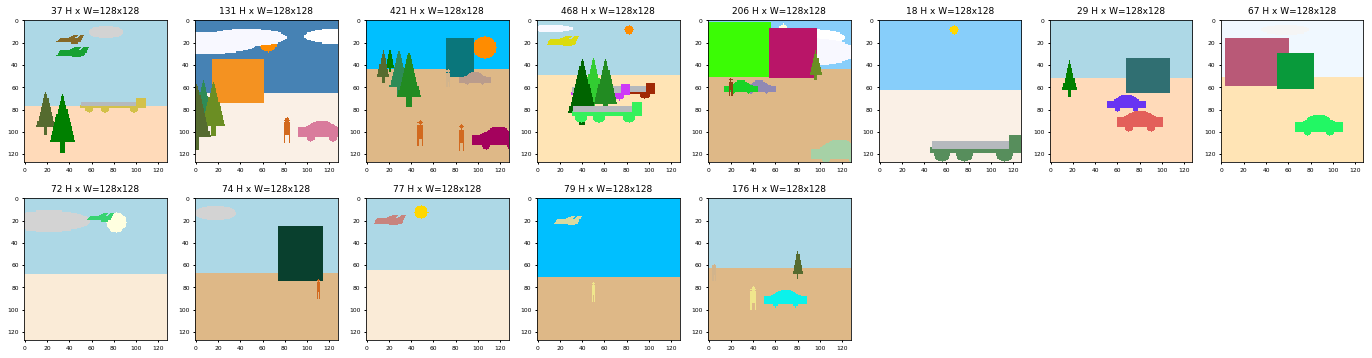

In [5]:
# image_list = list(range(160,200))
# image_list = list(range(0, 80))
image_list = [37, 131, 421, 468, 206 , 18, 29, 67, 72, 74, 77, 79, 176]
image_titles = [str(i) for i in image_list]

images = get_image_batch(dataset_test, image_list)
visualize.display_images(images, titles = image_titles, cols = 8, width = 24)

##  Manipulate some images to test contextual relationships

|Exp |Image     | Original Image | modifications |Conxtextual experiment
|----| :------- |:-------------- | :-------------|:------------------------------------------------------------------ 
| 1 | Image 18 | sun and truck | Remove sun, add building |  move truck around with and without a building present in the image
| 2 | image 67 | Buildings and car|                    | If we move a person around the activation "should" peak when it's in proper position with regards to the car.
| 3 | image 67 | Buildings and car| Remove all objects | and move an object of each class around in black, and in color. 
| 4 | Image 72 | sun and airplane | Remove sun         | move a car around the image, and move a truck around the image , comparing the results. Moving a truck should invoke higher activation than a car, since the cars do not cooccur with an airplane
| 5 | Image 77 | Sun, Airplane    | Remove sun         | move airplane around with and and without a building present in the scene. The activation strength should increase when the building is absent
| 6 | Image 79 | Person, plane | Remove the plane | move a car around the image. Activation of the car should peak when it's in propoer position with regards to the person
| 7 | image 176| 2 persons, tree, car| Remove tree and persons | move a airplane around (car and airplane dont occur in same image - so the relatvie activation strength of the airplane, in proper position, should be higher when thecar is absent from the image
    
    - The max FCN activation of the person is close to the car
 

####  Objects to add / remove from image s

In [ ]:
## image 77: [('sun', (255.0, 215.0, 0.0), (49, 13, 6, 6)), ('airplane', (200.0, 132.0, 126.0), (25, 23, 18, 7))]
## image 27 : [ ('sun', (255.0, 255.0, 224.0), (87, 16, 7, 7)),   ('building', (7.0, 9.0, 197.0), (92, 60, 24, 20)),   ('person', (210.0, 105.0, 30.0), (124, 107, 2, 11))]

# del dataset_test.image_info[image_id]['shapes'][0:2]
# black_car  = ('car', black, (cx, cy, 15, 7))
# black_car = ('car', (0.0, 0.0, 0.0),(64,64, 15, 7))
# person = ('person', (139.0, 69.0, 19.0), (17, 92, 2, 10))
## person = ('person', (240.0, 230.0, 140.0), (40, 92, 2, 10))
## black_sun = ('sun', (0.0, 0.0, 0.0), (7, 9, 4, 4))
building  =  ('building', (7.0, 9.0, 197.0), (92, 60, 24, 20))
airplane  = ('airplane', (200.0, 132.0, 126.0), (25, 23, 18, 7))
car       = ('car', (150.0, 174.0, 8.0), (87, 112, 22, 11))
truck     = ('truck', (213.0, 56.0, 119.0), (80, 93, 39, 13))
truck     = ('truck', (83.0, 192.0, 78.0), (65, 71, 25, 8))
tree      = ('tree', (50.0, 205.0, 50.0), (100, 91, 12, 28))
cloud     = ('cloud', (192.0, 192.0, 192.0), (106, 20, 34, 8))
sun       = ('sun', (255.0, 140.0, 0.0), (66, 18, 7, 7)),

[ ('building', (48.0, 111.0, 114.0), (87, 50, 19, 15)),
  ('tree', (0.0, 128.0, 0.0), (17, 53, 6, 16)),
  ('car', (104.0, 52.0, 242.0), (68, 76, 17, 8)),
  ('car', (227.0, 95.0, 90.0), (80, 92, 20, 10))]
 Image_id    :  29  Reference:  [('building', (48.0, 111.0, 114.0), (87, 50, 19, 15)), ('tree', (0.0, 128.0, 0.0), (17, 53, 6, 16)), ('car', (104.0, 52.0, 242.0), (68, 76, 17, 8)), ('car', (227.0, 95.0, 90.0), (80, 92, 20, 10))] Coco Id: 29
 Image meta  :  [    29    128    128      3      0      0    128    128      1      1]
 Class ids   :  (4,)    [     4      5      2      2]
 Class Names :  ['building', 'tree', 'car', 'car']


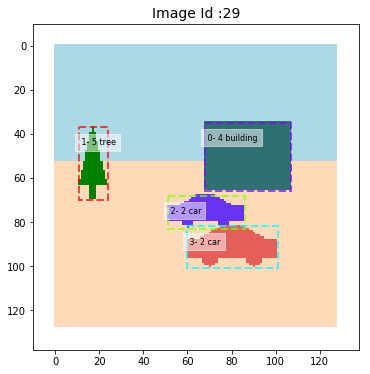

In [43]:
# pp.pprint(dataset_test.image_info[20]['shapes'])
show_id = 29
pp.pprint(dataset_test.image_info[show_id]['shapes'])
vis.display_image_gt(dataset_test, dataset_test.config, show_id, size=6, verbose = True)

## Weight Files

In [5]:
# MRCNN_DIR_WEIGHTS =  'F:/models_newshapes/train_mrcnn_newshapes/mrcnn20181216T0000'
MRCNN_DIR_WEIGHTS = '/home/kbardool/models_newshapes2/train_mrcnn/mrcnn20190318T0000'
# files = ['fcn_0001.h5','fcn_0027.h5','fcn_0036.h5','fcn_0051.h5','fcn_0076.h5','fcn_0106.h5','fcn_0156.h5']
# files   = ['fcn_0104.h5','fcn_0150.h5','fcn_0205.h5','fcn_0249.h5','fcn_0293.h5','fcn_0346.h5','fcn_0419.h5']
mrcnn_files   = ['mrcnn_0001.h5', 'mrcnn_0020.h5', 'mrcnn_0041.h5', 'mrcnn_0060.h5',
                 'mrcnn_0092.h5', 'mrcnn_0116.h5', 'mrcnn_0154.h5', 'mrcnn_0174.h5',
                 'mrcnn_0201.h5', 'mrcnn_0223.h5', 'mrcnn_0243.h5', 'mrcnn_0332.h5']

MRCNN_FILE_IDX = -2

In [6]:
# FCN_DIR_WEIGHTS =  'F:/models_newshapes/train_fcn8_l2_newshapes/fcn20181224T0000' ### Training with LR=0.00001, MSE Loss NO L2 Regularization
# fcn_files = ['fcn_0001.h5', 'fcn_0150.h5', 'fcn_0346.h5', 'fcn_0421.h5',
#              'fcn_0450.h5', 'fcn_0482.h5', 'fcn_0521.h5', 'fcn_0610.h5',
#              'fcn_0687.h5', 'fcn_0793.h5', 'fcn_0821.h5', 'fcn_0940.h5',
#              'fcn_1012.h5', 'fcn_1127.h5', 'fcn_1644.h5', 'fcn_1776.h5',
#               'fcn_1848.h5', 'fcn_2017.h5', 'fcn_2084.h5', 'fcn_x0434.h5', 'fcn_x0419.h5']
FCN_DIR_WEIGHTS =  '/home/kbardool/models_newshapes2/train_fcn8L2_BCE/fcn20190323T0000'
fcn_files  = ['fcn_0001.h5', 'fcn_0002.h5', 'fcn_0003.h5', 'fcn_0004.h5', 
              'fcn_0005.h5', 'fcn_0006.h5', 'fcn_0008.h5', 'fcn_0009.h5', 
              'fcn_0012.h5', 'fcn_0016.h5', 'fcn_0018.h5', 'fcn_0019.h5', 
              'fcn_0021.h5', 'fcn_0022.h5', 'fcn_0023.h5', 'fcn_0024.h5', 
              'fcn_0033.h5', 'fcn_0039.h5', 'fcn_0042.h5', 'fcn_0044.h5', 
              'fcn_0077.h5', 'fcn_0089.h5', 'fcn_0170.h5', 'fcn_0177.h5',
              'fcn_0253.h5', 'fcn_0266.h5']  ## 22,23,24,25
FILE_IDX = -1

## Display FCN output heatmaps for a series of epoch files

In [15]:
save_path = "/home/kbardool/git_projs/mrcnn3/train_newshapes_2/other"
exp_prfx = 'exp5'
exp_desc = 'sun_black'
cols = 9 
image_id = 79
classes = [1,2,3,4,5,6,7,8]

epochs = fcn_files[FILE_IDX].split('_')[1].replace('.h5','')
mrcnn_epochs = mrcnn_files[MRCNN_FILE_IDX].split('_')[1].replace('.h5','')
load_file =  exp_prfx+'_i'+str(image_id)+'_e'+epochs+'_m'+mrcnn_epochs+'_'+exp_desc+'.npz'
print(' LOAD FILENAME:', load_file)

filename  = os.path.join(save_path, load_file)

if os.path.exists(filename):
    print('  input file: ', filename)
    loaddata = np.load(os.path.join(save_path, load_file))
    pr_agg_hm         = loaddata['fcn_agg_hm']
    pr_agg_hm_clipped = loaddata['pr_agg_hm_clipped']
    fcn_agg_hm         = loaddata['fcn_agg_hm']
    fcn_agg_hm_clipped = loaddata['fcn_agg_hm_clipped']
    gt_cls_counts      = loaddata['gt_cls_counts']  
    dt_cls_counts      = loaddata['dt_cls_counts']      
    if 'orig_scores' in loaddata:
        print(' orig_scores exists')
        orig_scores         = loaddata['orig_scores']
    else:
        print('  orig scores doesn''t exist ')
    fcn_scores         = loaddata['fcn_scores']
    pr_scores          = loaddata['pr_scores']
else: 
    print(' file not found ', filename)

ttl = 'fcn hm - img '+str(image_id)+'  epoch:'+str(epochs) +'  '+ exp_desc 

 LOAD FILENAME: exp5_i79_e0266_m0243_sun_black.npz
  input file:  /home/kbardool/git_projs/mrcnn3/train_newshapes_2/other/exp5_i79_e0266_m0243_sun_black.npz
 orig_scores exists


 Num features:  5 Rows / Columns:  1 5


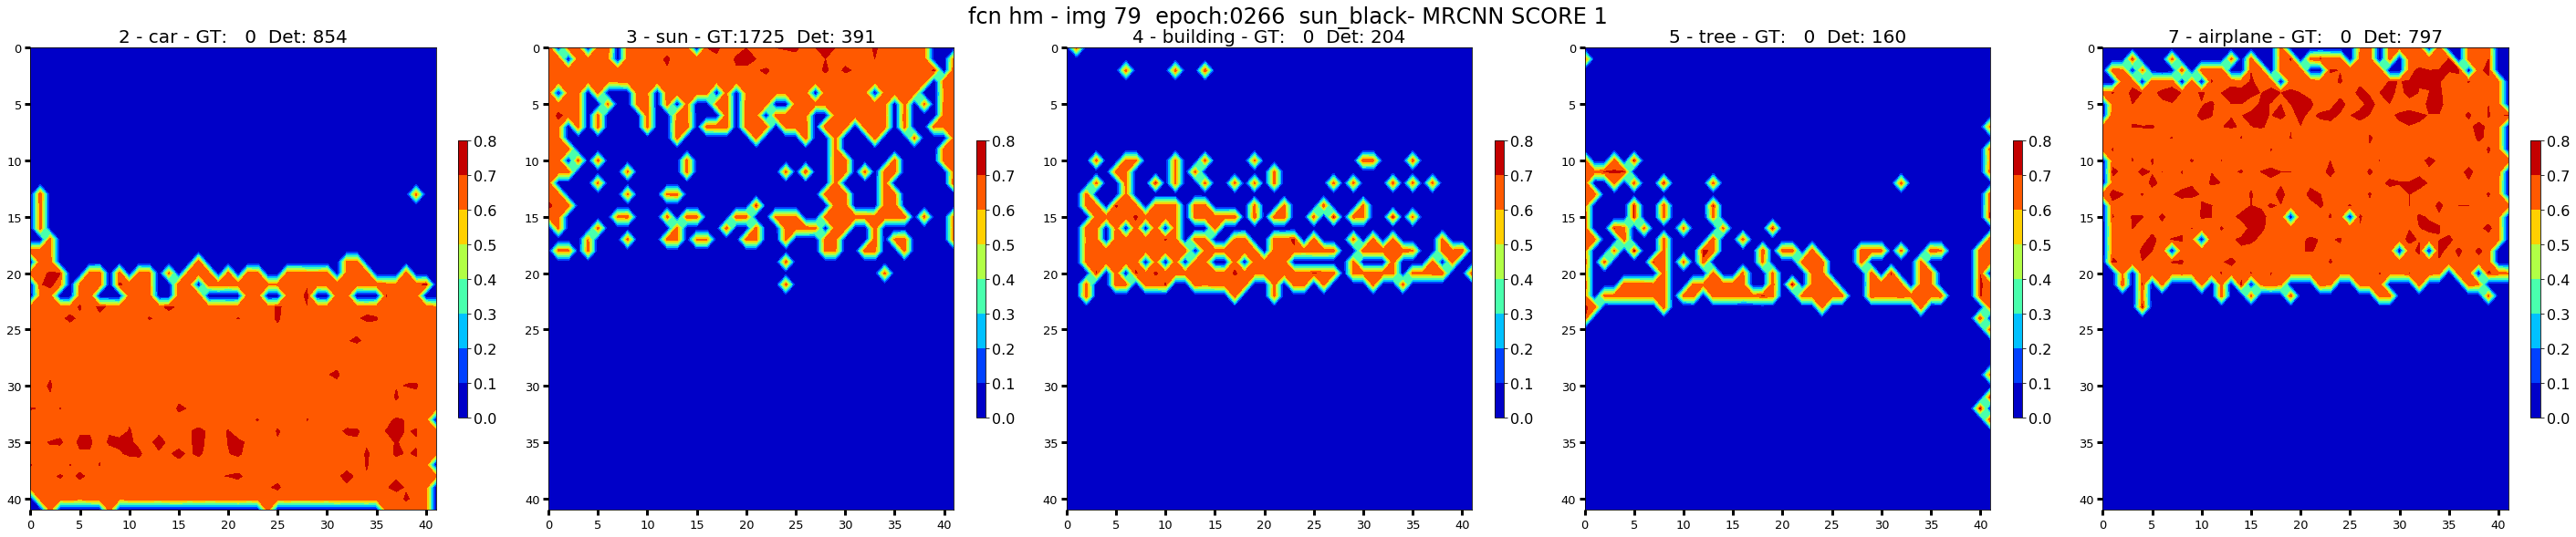

 Num features:  5 Rows / Columns:  1 5


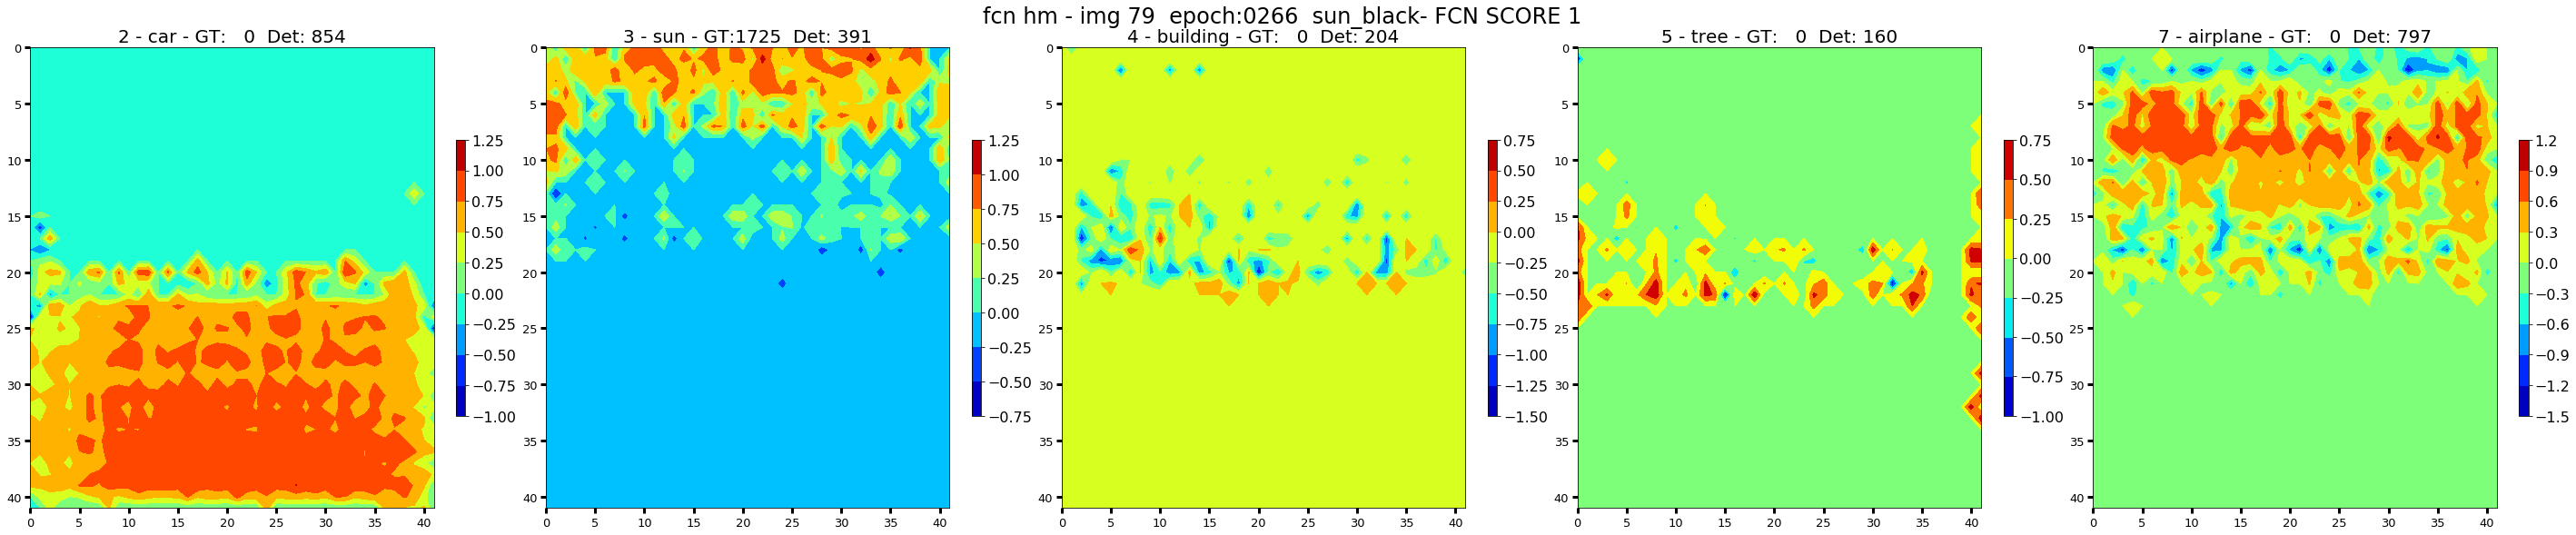

 Num features:  5 Rows / Columns:  1 5


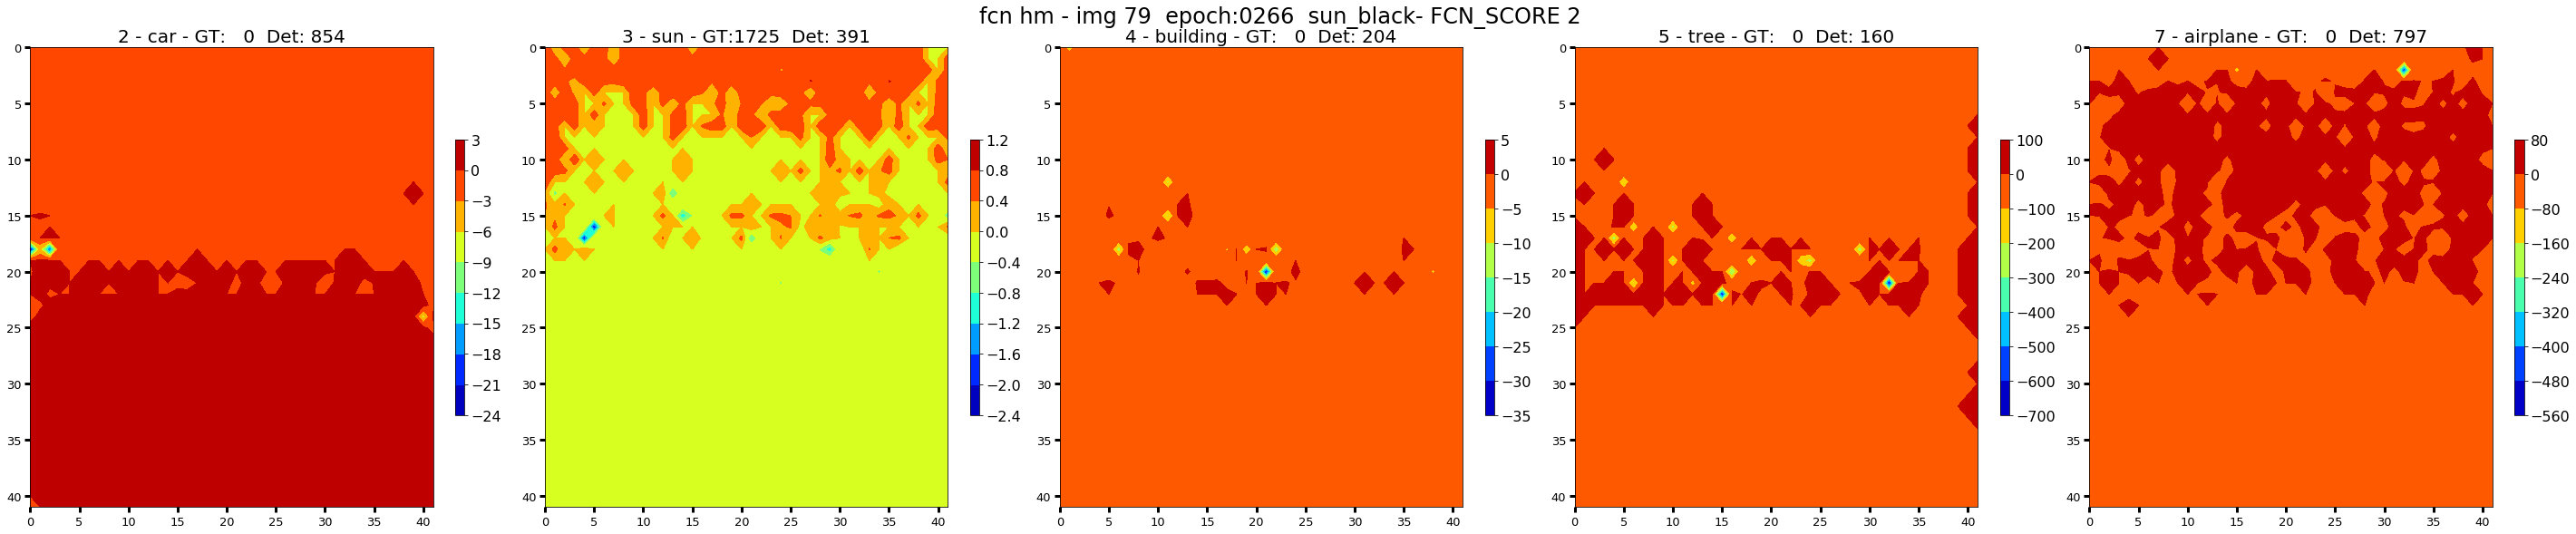

In [16]:
# print(ttl, cols)
classes = [1,2,3,4,5,6,7,8]
# classes = [2,3,4,5,6,7,8]
classes = [2,3,4,5,7]
_ =vis2.display_score_contours(pr_scores[0]  , gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- MRCNN SCORE 1 ', classes = classes)
_ =vis2.display_score_contours(fcn_scores[0], gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- FCN SCORE 1 ', classes = classes)
_ =vis2.display_score_contours(fcn_scores[1], gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- FCN_SCORE 2 ', classes = classes)


exp6_i79_e0266_m0243_sun.npz
 Num features:  2 Rows / Columns:  2 3


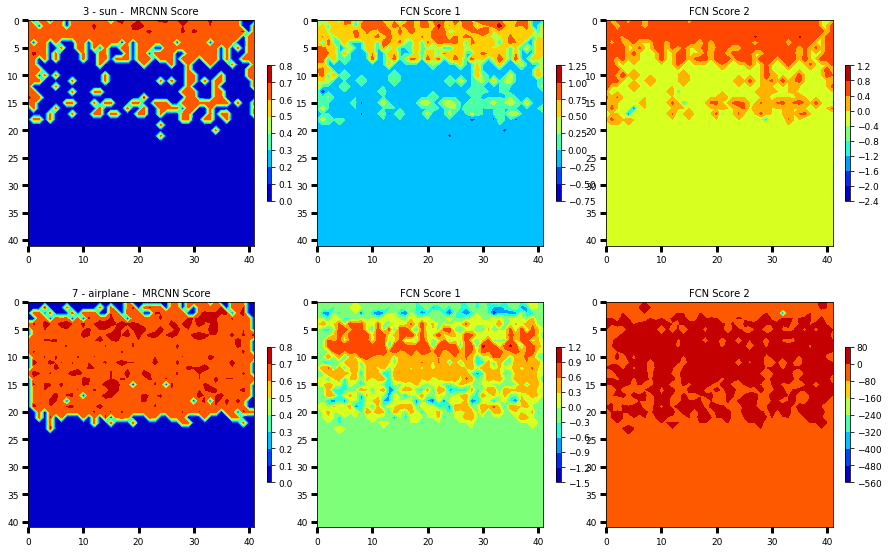

In [28]:
classes = [1,2,3,4,5,6,7,8]
classes = [3,7]
print(save_file)
_ =vis2.display_score_contours_compare(pr_scores, fcn_scores, class_names,  classes = classes)

(9, 1, 1)


../mrcnn/visualize_2.py:905: RuntimeWarning: invalid value encountered in true_divide
  out /= (x.max(axis=(1,2), keepdims = True) - x.min(axis=(1,2), keepdims = True))


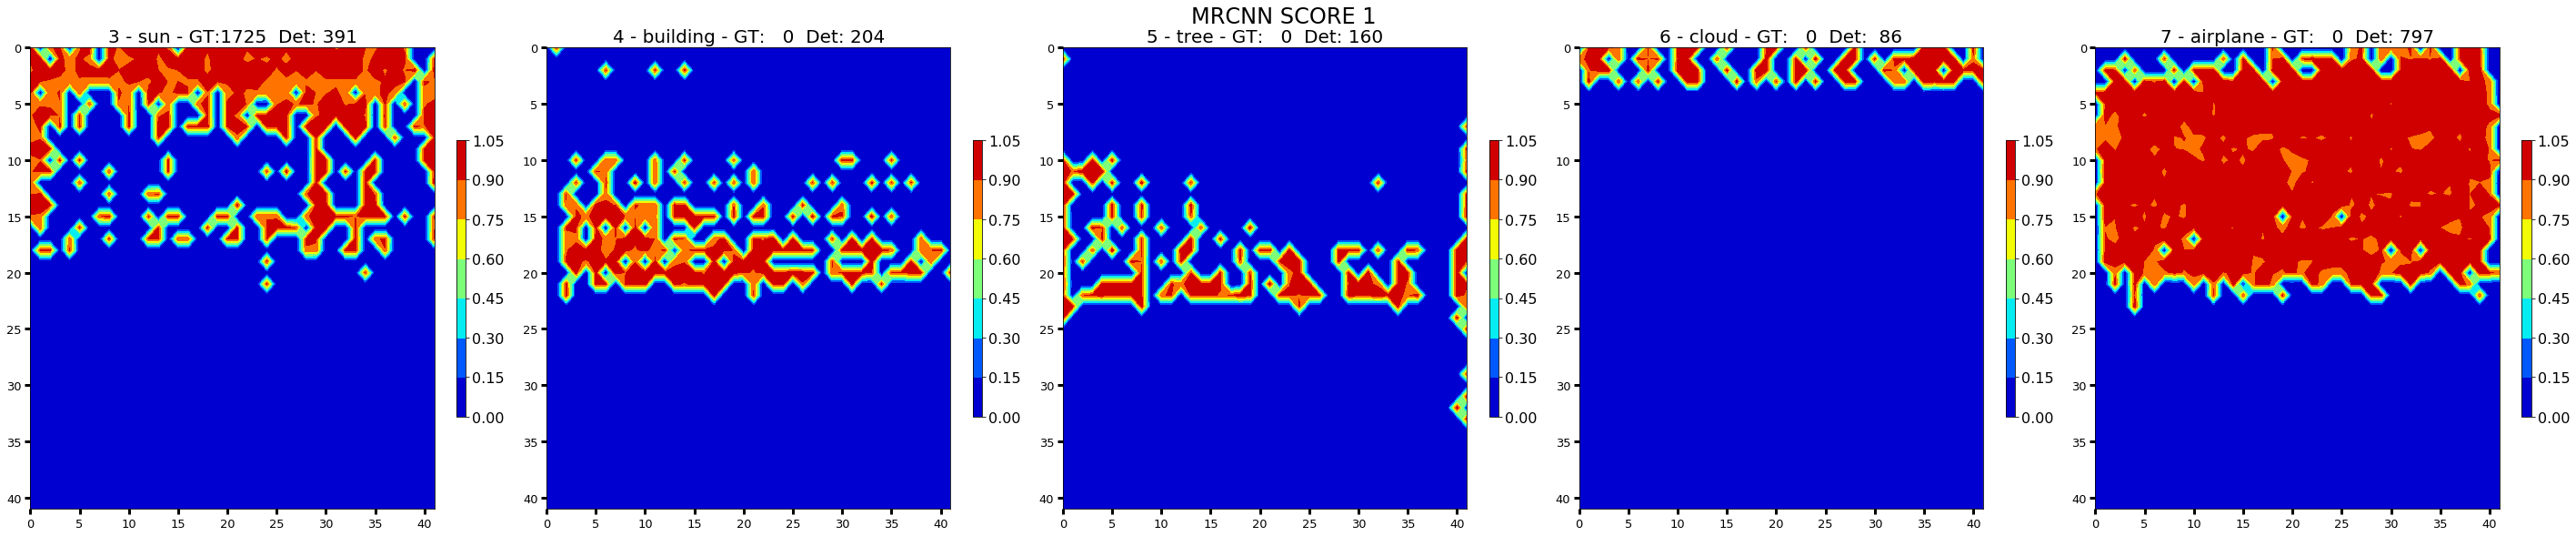

(9, 1, 1)


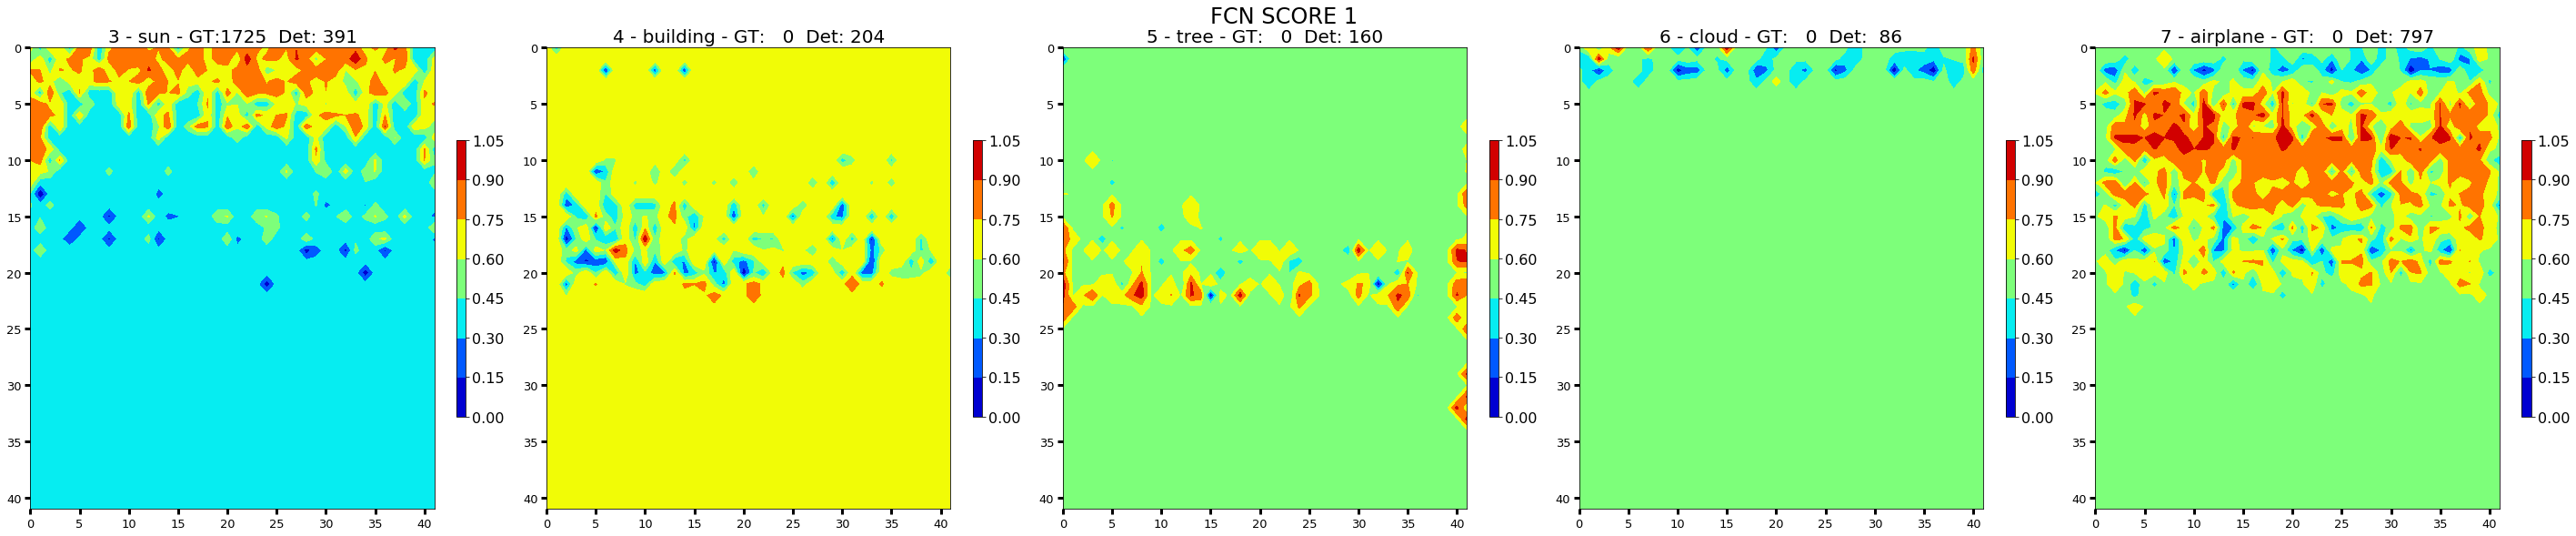

(9, 42, 42)


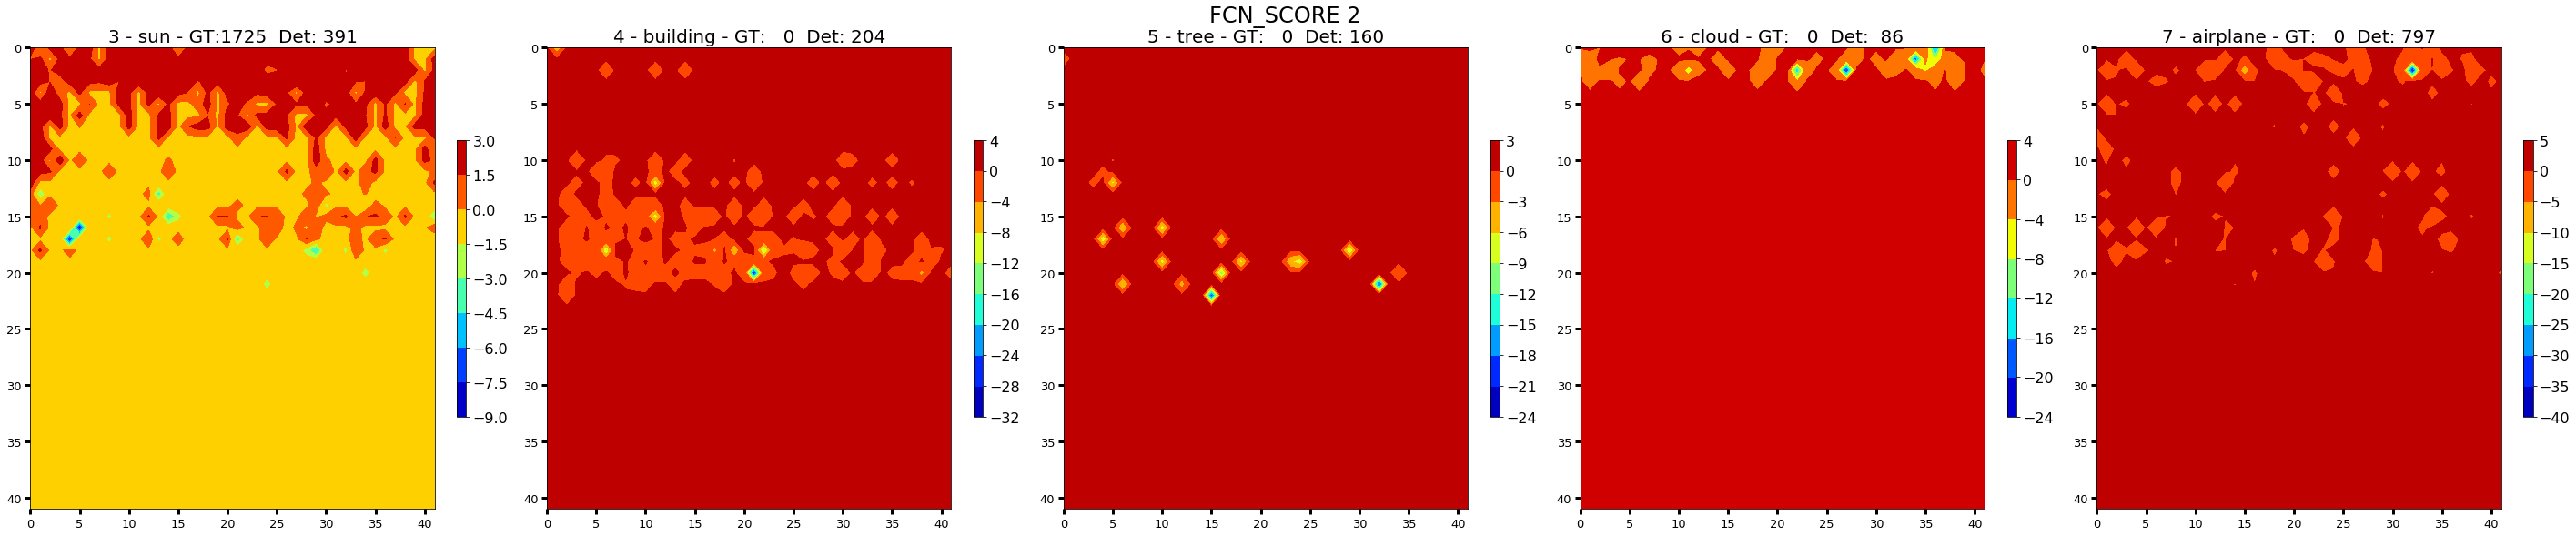

In [31]:
# print(ttl, cols)
# # classes = [1,2,3,4,5,6,7,8],2, keepdims=True
# classes = [2,3,4,6,7,8]
classes = [3,4,5,6,7]
# print(results['fcn_scores'][1].shape, p1.shape)
# p1 = np.linalg.norm(results['pr_scores'][0],1, axis = (1,2), keepdims=True)
_ =vis2.display_score_contours(vis2.normalize_fcn_score(pr_scores[0]) , gt_cls_counts, dt_cls_counts, class_names, title = 'MRCNN SCORE 1 ', classes = classes)
# _ =vis2.display_score_contours(results['pr_scores'][0]/p1 , gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- MRCNN SCORE 1 ', classes = classes)


# p1 = np.linalg.norm(results['fcn_scores'][0],1, axis = (1,2), keepdims=True)
_ =vis2.display_score_contours(vis2.normalize_fcn_score(fcn_scores[0]), gt_cls_counts, dt_cls_counts, class_names, title ='FCN SCORE 1 ', classes = classes)
# _ =vis2.display_score_contours(results['fcn_scores'][0]/p1, gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- FCN SCORE 1 ', classes = classes)


# p1 = np.linalg.norm(results['fcn_scores'][1],1, axis = (1,2), keepdims=True)
_ =vis2.display_score_contours(vis2.standardize_fcn_score(fcn_scores[1]), gt_cls_counts, dt_cls_counts, class_names, title = 'FCN_SCORE 2 ', classes = classes)
# _ =vis2.display_score_contours(results['fcn_scores'][1]/p1, gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- FCN_SCORE 2 ', classes = classes)

## Load and Display Sun Heatmaps

###  Yellow Sun

In [ ]:
save_path = "/home/kbardool/git_projs/mrcnn3/train_newshapes_2/other"
exp_prfx = 'exp5'
cols = 9 
classes = [1,2,3,4,5,6,7,8]

In [23]:
exp_desc = 'car_black'
image_id = 79
epochs = fcn_files[FILE_IDX].split('_')[1].replace('.h5','')
mrcnn_epochs = mrcnn_files[MRCNN_FILE_IDX].split('_')[1].replace('.h5','')
load_file =  exp_prfx+'_i'+str(image_id)+'_e'+epochs+'_m'+mrcnn_epochs+'_'+exp_desc+'.npz'
print(' LOAD FILENAME:', load_file)

filename  = os.path.join(save_path, load_file)

if os.path.exists(filename):
    print('  input file: ', filename)
    loaddata = np.load(os.path.join(save_path, load_file))
    pr_agg_hm         = loaddata['fcn_agg_hm']
    pr_agg_hm_clipped = loaddata['pr_agg_hm_clipped']
    fcn_agg_hm         = loaddata['fcn_agg_hm']
    fcn_agg_hm_clipped = loaddata['fcn_agg_hm_clipped']
    gt_cls_counts      = loaddata['gt_cls_counts']  
    dt_cls_counts      = loaddata['dt_cls_counts']      
    if 'orig_scores' in loaddata:
        print(' orig_scores exists')
        orig_scores         = loaddata['orig_scores']
    else:
        print('  orig scores doesn''t exist ')
    fcn_scores         = loaddata['fcn_scores']
    pr_scores          = loaddata['pr_scores']
else: 
    print(' file not found ', filename)

ttl = 'fcn hm - img '+str(image_id)+'  epoch:'+str(epochs) +'  '+ exp_desc 

 LOAD FILENAME: exp5_i79_e0266_m0243_car_black.npz
  input file:  /home/kbardool/git_projs/mrcnn3/train_newshapes_2/other/exp5_i79_e0266_m0243_car_black.npz
 orig_scores exists


exp5_i79_e0266_m0243_car_black.npz
 Num features:  5 Rows / Columns:  1 5


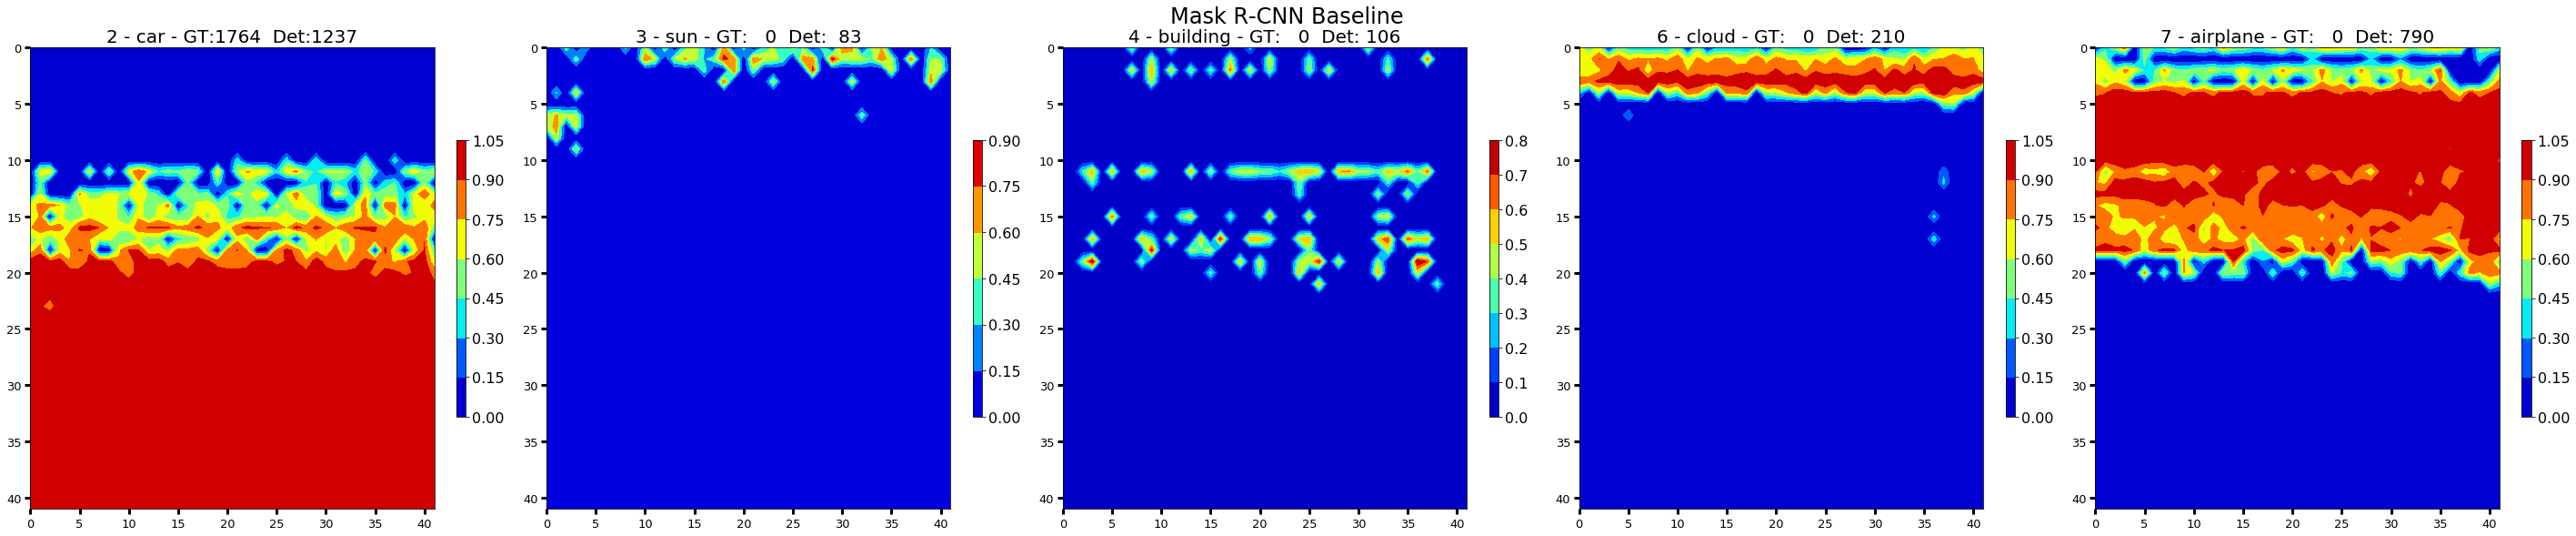

In [24]:
# print(ttl, cols)
classes = [1,2,3,4,5,6,7,8]
# classes = [1,3,4,5,6,7]
# classes = [1,4,5]
# classes = [1,2,3,5]
classes = [2,3,4,6,7]

print(load_file)
_ =vis2.display_score_contours(orig_scores[0]  , gt_cls_counts, dt_cls_counts, class_names, title ='Mask R-CNN Baseline', classes = classes)
# _ =vis2.display_score_contours(pr_scores[0]  , gt_cls_counts, dt_cls_counts, class_names, title ='MRCNN SCORE 1 ', classes = classes)
# _ =vis2.display_score_contours(fcn_scores[0], gt_cls_counts, dt_cls_counts, class_names, title = 'FCN SCORE 1 ', classes = classes)
# _ =vis2.display_score_contours(fcn_scores[1], gt_cls_counts, dt_cls_counts, class_names, title = 'FCN_SCORE 2 ', classes = classes)

In [27]:
exp_desc = 'car_color'
image_id = 79
epochs = fcn_files[FILE_IDX].split('_')[1].replace('.h5','')
mrcnn_epochs = mrcnn_files[MRCNN_FILE_IDX].split('_')[1].replace('.h5','')
load_file =  exp_prfx+'_i'+str(image_id)+'_e'+epochs+'_m'+mrcnn_epochs+'_'+exp_desc+'.npz'
print(' LOAD FILENAME:', load_file)

filename  = os.path.join(save_path, load_file)

if os.path.exists(filename):
    print('  input file: ', filename)
    loaddata = np.load(os.path.join(save_path, load_file))
    pr_agg_hm         = loaddata['fcn_agg_hm']
    pr_agg_hm_clipped = loaddata['pr_agg_hm_clipped']
    fcn_agg_hm         = loaddata['fcn_agg_hm']
    fcn_agg_hm_clipped = loaddata['fcn_agg_hm_clipped']
    gt_cls_counts      = loaddata['gt_cls_counts']  
    dt_cls_counts      = loaddata['dt_cls_counts']      
    if 'orig_scores' in loaddata:
        print(' orig_scores exists')
        orig_scores         = loaddata['orig_scores']
    else:
        print('  orig scores doesn''t exist ')
    fcn_scores         = loaddata['fcn_scores']
    pr_scores          = loaddata['pr_scores']
else: 
    print(' file not found ', filename)

ttl = 'fcn hm - img '+str(image_id)+'  epoch:'+str(epochs) +'  '+ exp_desc 

 LOAD FILENAME: exp5_i79_e0266_m0243_car_color.npz
  input file:  /home/kbardool/git_projs/mrcnn3/train_newshapes_2/other/exp5_i79_e0266_m0243_car_color.npz
 orig_scores exists


exp5_i79_e0266_m0243_car_color.npz
 Num features:  5 Rows / Columns:  1 5


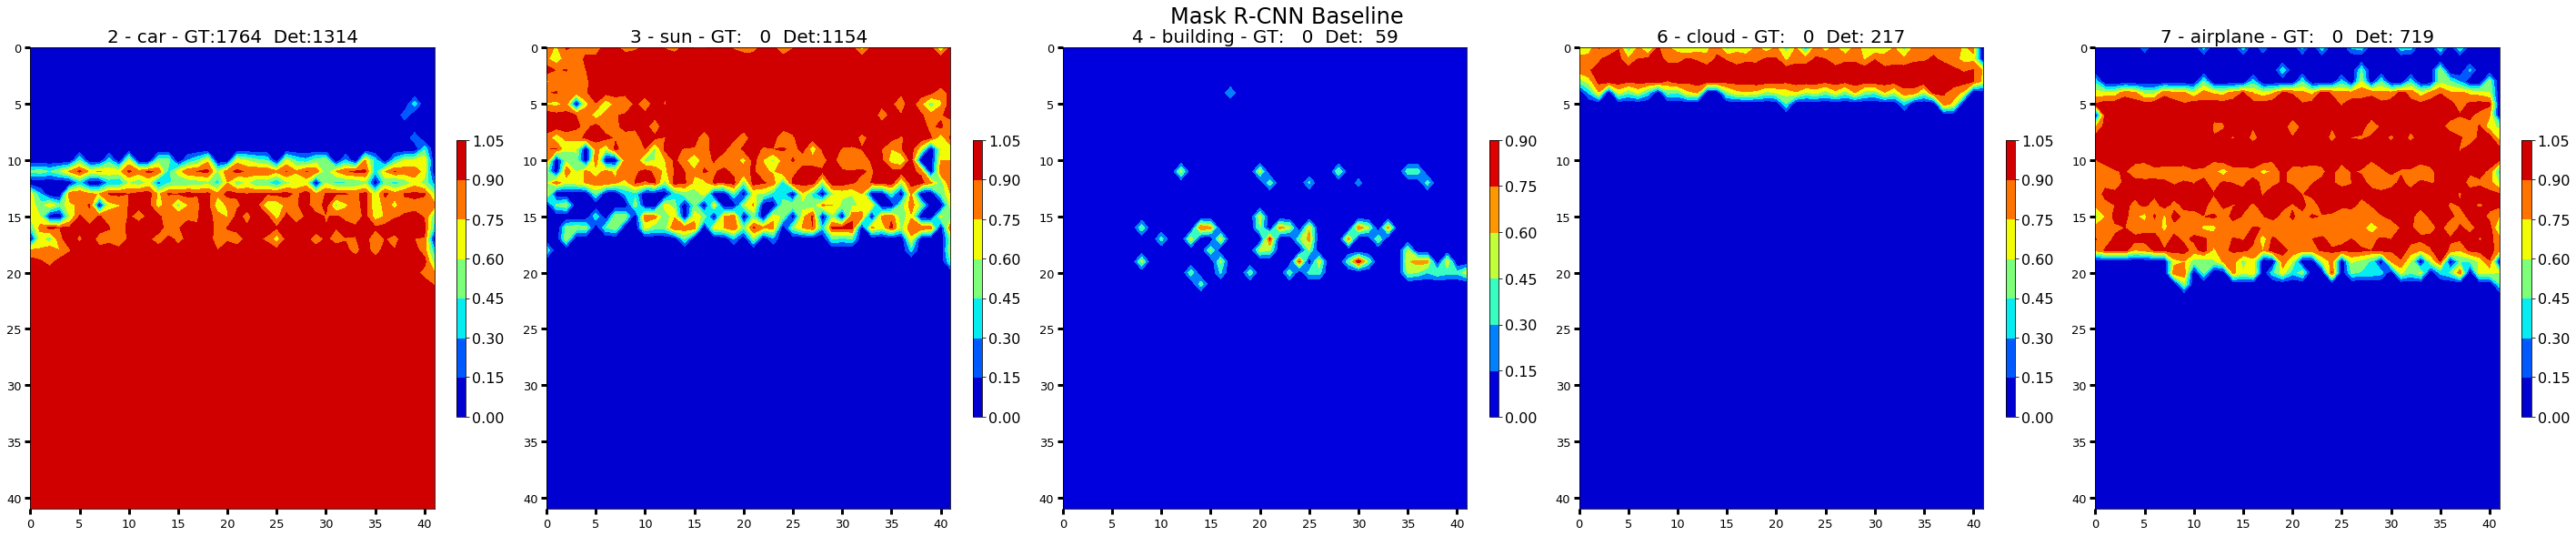

In [28]:
classes = [2,3,4,6,7]

print(load_file)
_ =vis2.display_score_contours(orig_scores[0]  , gt_cls_counts, dt_cls_counts, class_names, title ='Mask R-CNN Baseline', classes = classes)


#### Compare Yellow Sun scores

exp5_i79_e0266_m0243_sun_yellow.npz
 Num features:  2 Rows / Columns:  2 4


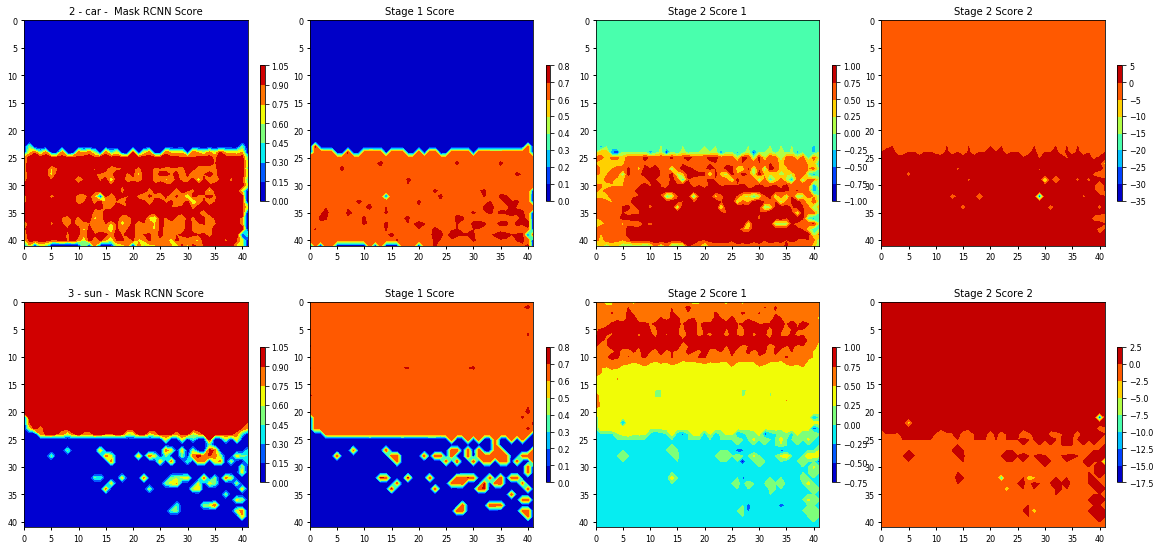

In [31]:
classes = [1,2,3,4,5,6,7,8]
classes = [2,3,5,7,8]
classes  = [2,3]

print(load_file)
# _ =vis2.display_score_contours_compare(pr_scores, fcn_scores, class_names,  classes = classes)
_ =vis2.display_score_contours_compare(pr_scores, fcn_scores, class_names,  classes = classes, orig_scores = orig_scores)

###  Black Sun

In [23]:
exp_desc = 'sun_black'
epochs = fcn_files[FILE_IDX].split('_')[1].replace('.h5','')
mrcnn_epochs = mrcnn_files[MRCNN_FILE_IDX].split('_')[1].replace('.h5','')
load_file =  exp_prfx+'_i'+str(image_id)+'_e'+epochs+'_m'+mrcnn_epochs+'_'+exp_desc+'.npz'
print(' LOAD FILENAME:', load_file)

filename  = os.path.join(save_path, load_file)

if os.path.exists(filename):
    print('  input file: ', filename)
    loaddata = np.load(os.path.join(save_path, load_file))
    pr_agg_hm         = loaddata['fcn_agg_hm']
    pr_agg_hm_clipped = loaddata['pr_agg_hm_clipped']
    fcn_agg_hm         = loaddata['fcn_agg_hm']
    fcn_agg_hm_clipped = loaddata['fcn_agg_hm_clipped']
    gt_cls_counts      = loaddata['gt_cls_counts']  
    dt_cls_counts      = loaddata['dt_cls_counts']      
    if 'orig_scores' in loaddata:
        print(' orig_scores exists')
        orig_scores         = loaddata['orig_scores']
    else:
        print('  orig scores doesn''t exist ')
    fcn_scores         = loaddata['fcn_scores']
    pr_scores          = loaddata['pr_scores']
else: 
    print(' file not found ', filename)

ttl = 'fcn hm - img '+str(image_id)+'  epoch:'+str(epochs) +'  '+ exp_desc 

 LOAD FILENAME: exp5_i79_e0266_m0243_sun_black.npz
  input file:  /home/kbardool/git_projs/mrcnn3/train_newshapes_2/other/exp5_i79_e0266_m0243_sun_black.npz
 orig_scores exists


exp5_i79_e0266_m0243_sun_black.npz
 Num features:  5 Rows / Columns:  1 5


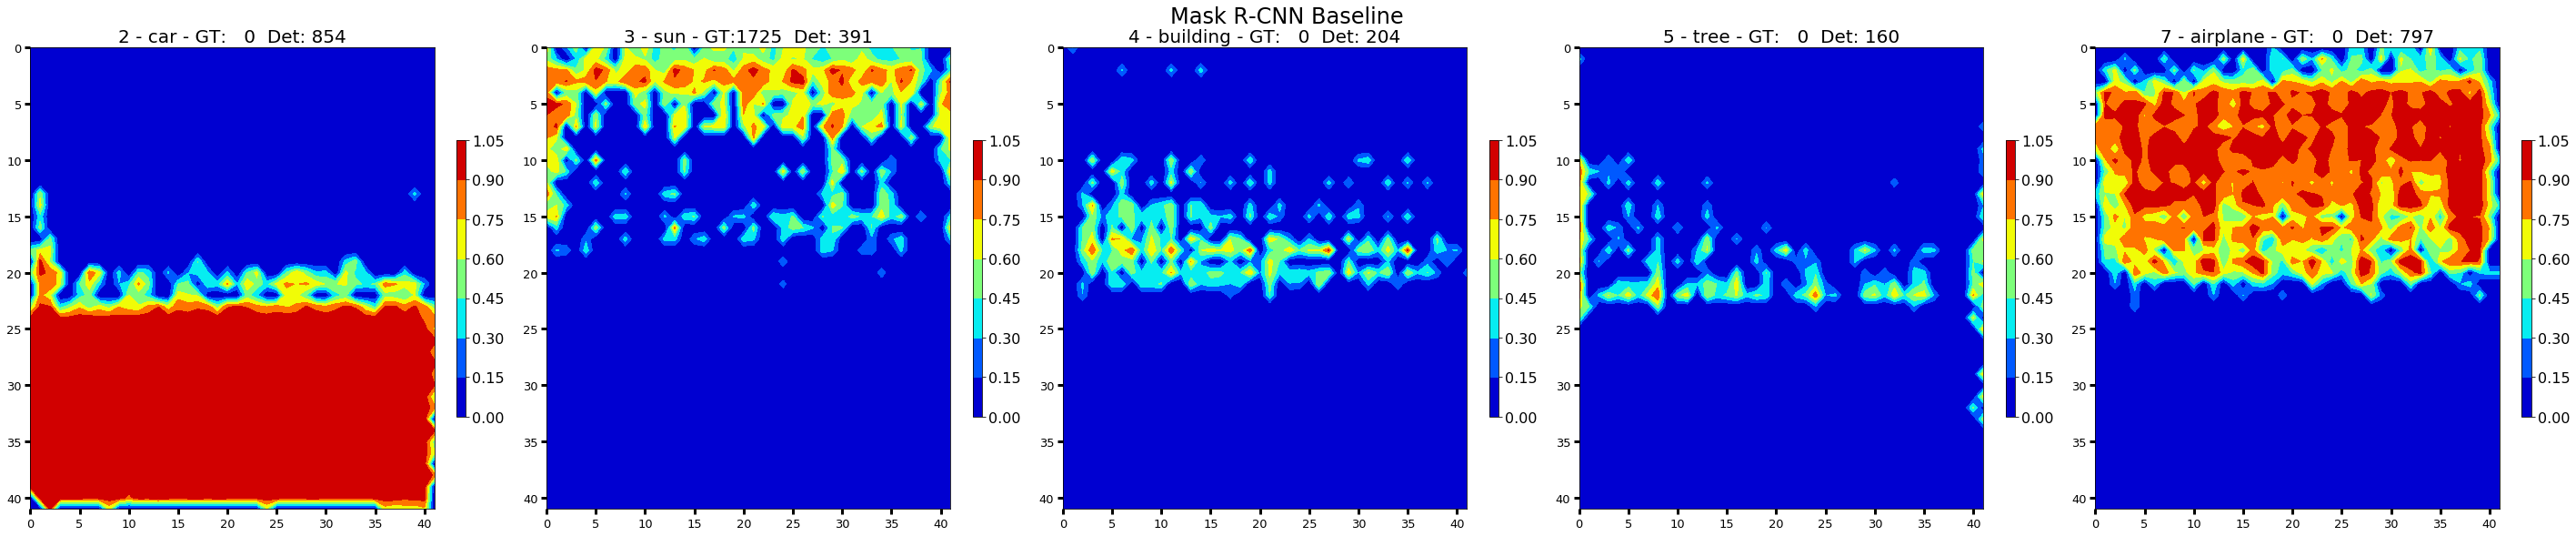

 Num features:  5 Rows / Columns:  1 5


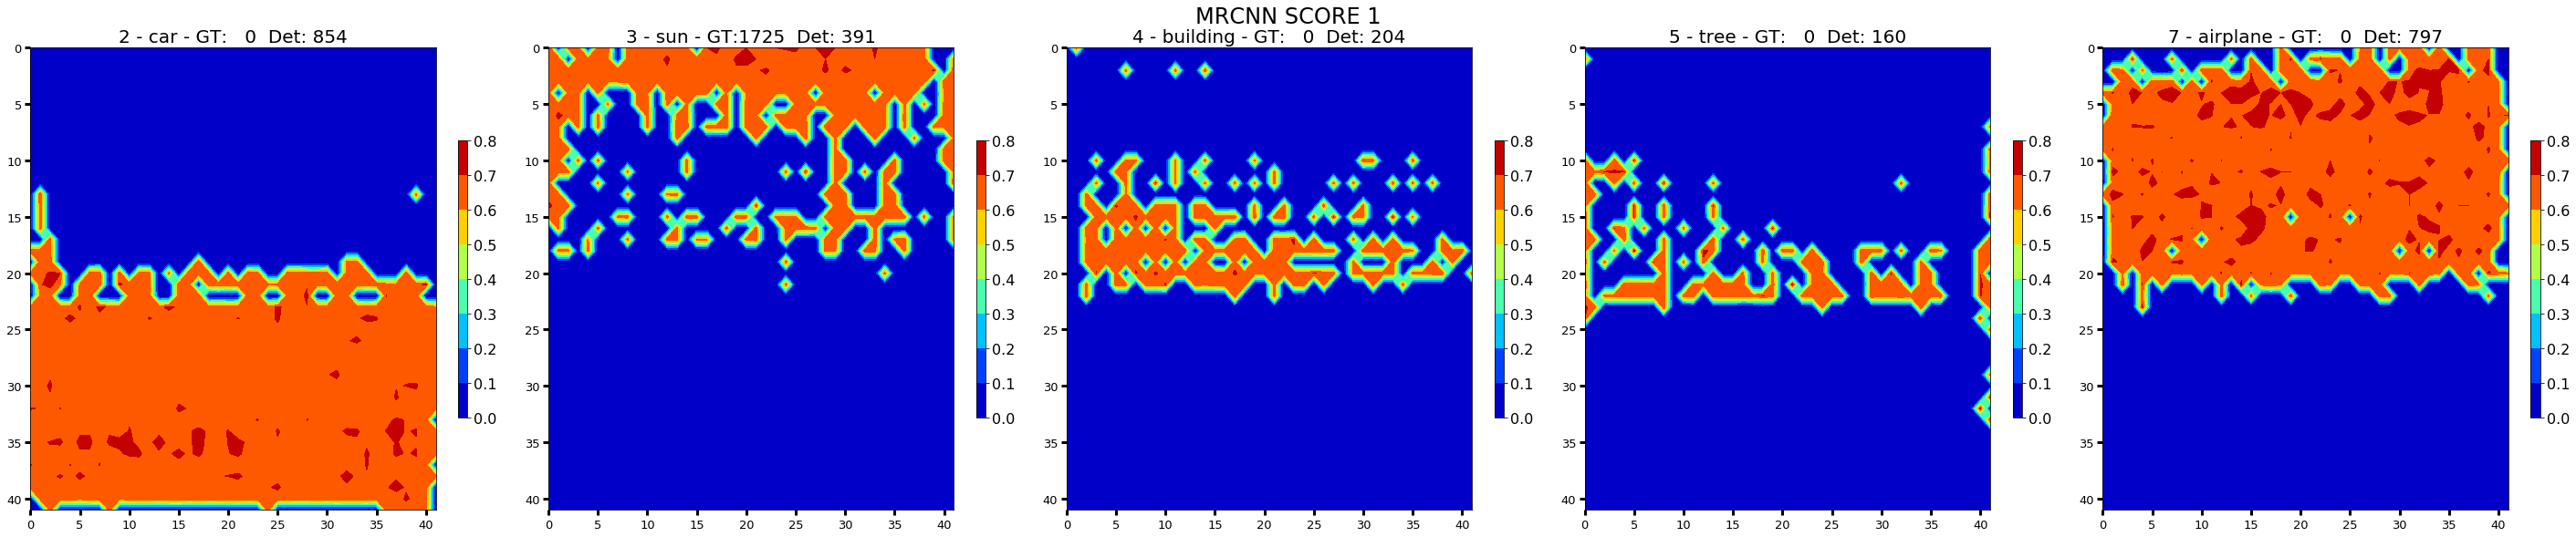

 Num features:  5 Rows / Columns:  1 5


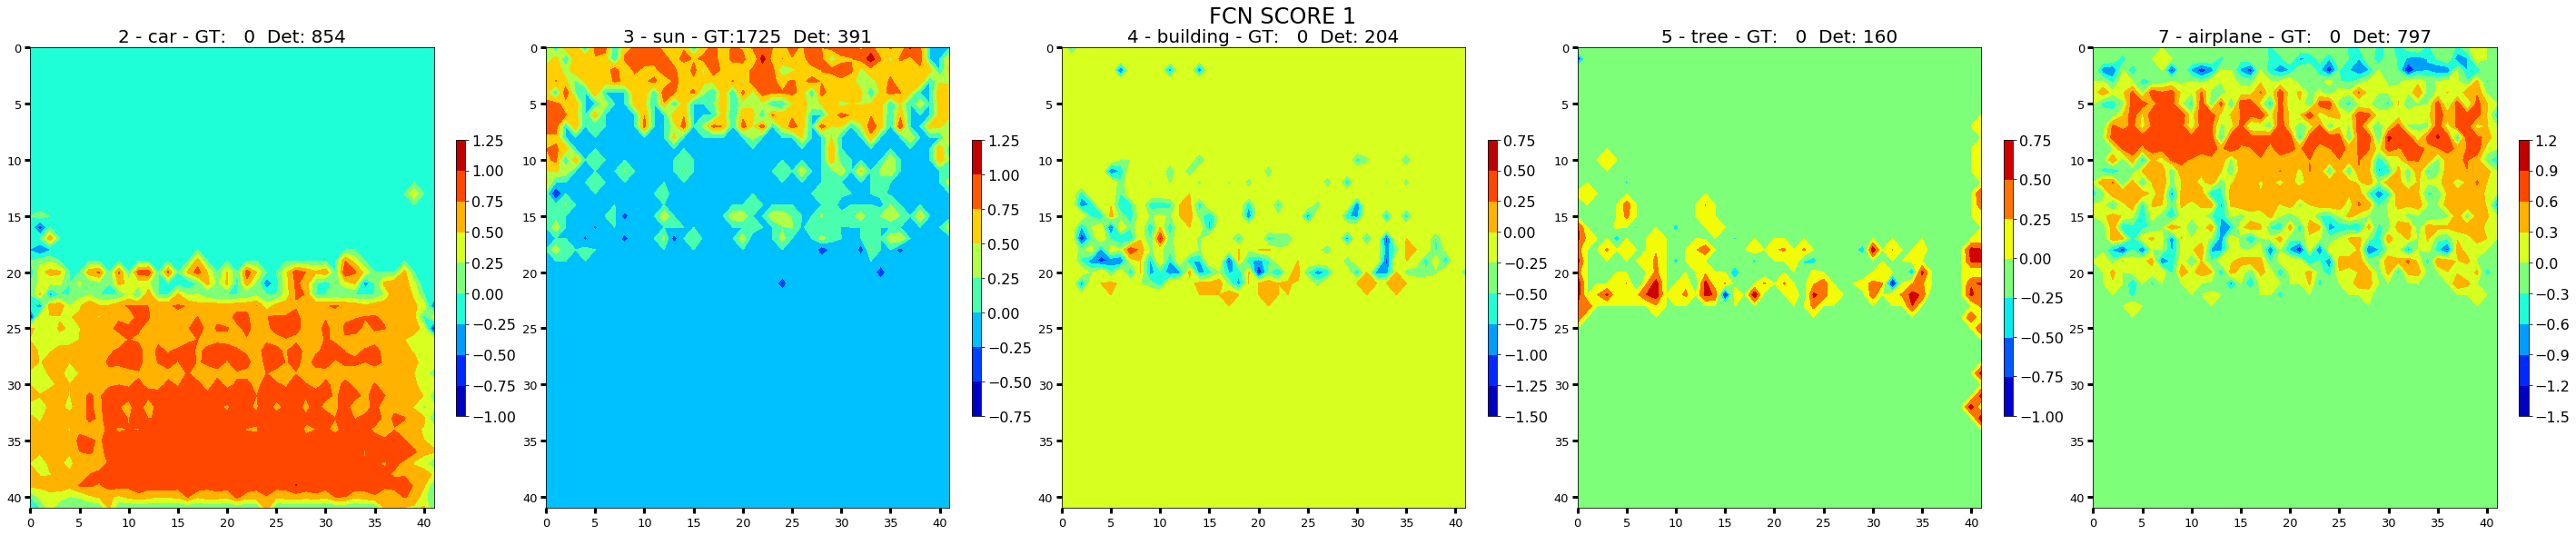

 Num features:  5 Rows / Columns:  1 5


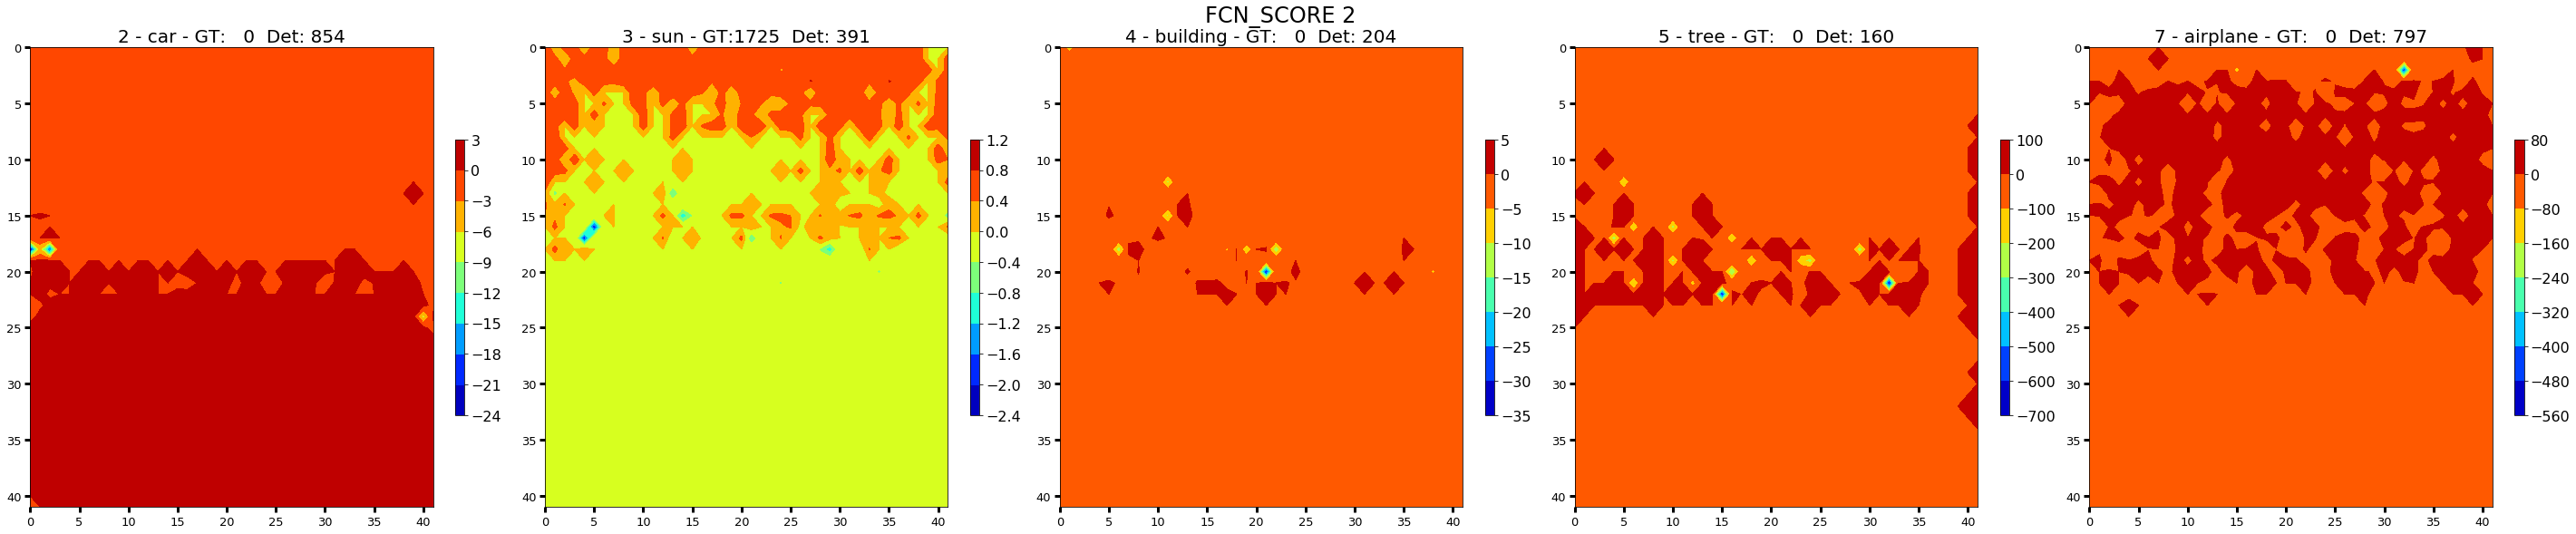

In [26]:
# print(ttl, cols)
classes = [1,2,3,4,5,6,7,8]
# classes = [1,3,4,5,6,7]
classes = [2,3,4,5,7]
# 
print(load_file)
_ =vis2.display_score_contours(orig_scores[0]  , gt_cls_counts, dt_cls_counts, class_names, title ='Mask R-CNN Baseline', classes = classes)
_ =vis2.display_score_contours(pr_scores[0]  , gt_cls_counts, dt_cls_counts, class_names, title ='MRCNN SCORE 1 ', classes = classes)
_ =vis2.display_score_contours(fcn_scores[0], gt_cls_counts, dt_cls_counts, class_names, title = 'FCN SCORE 1 ', classes = classes)
_ =vis2.display_score_contours(fcn_scores[1], gt_cls_counts, dt_cls_counts, class_names, title = 'FCN_SCORE 2 ', classes = classes)

exp5_i79_e0266_m0243_sun_black.npz
 Num features:  3 Rows / Columns:  3 4


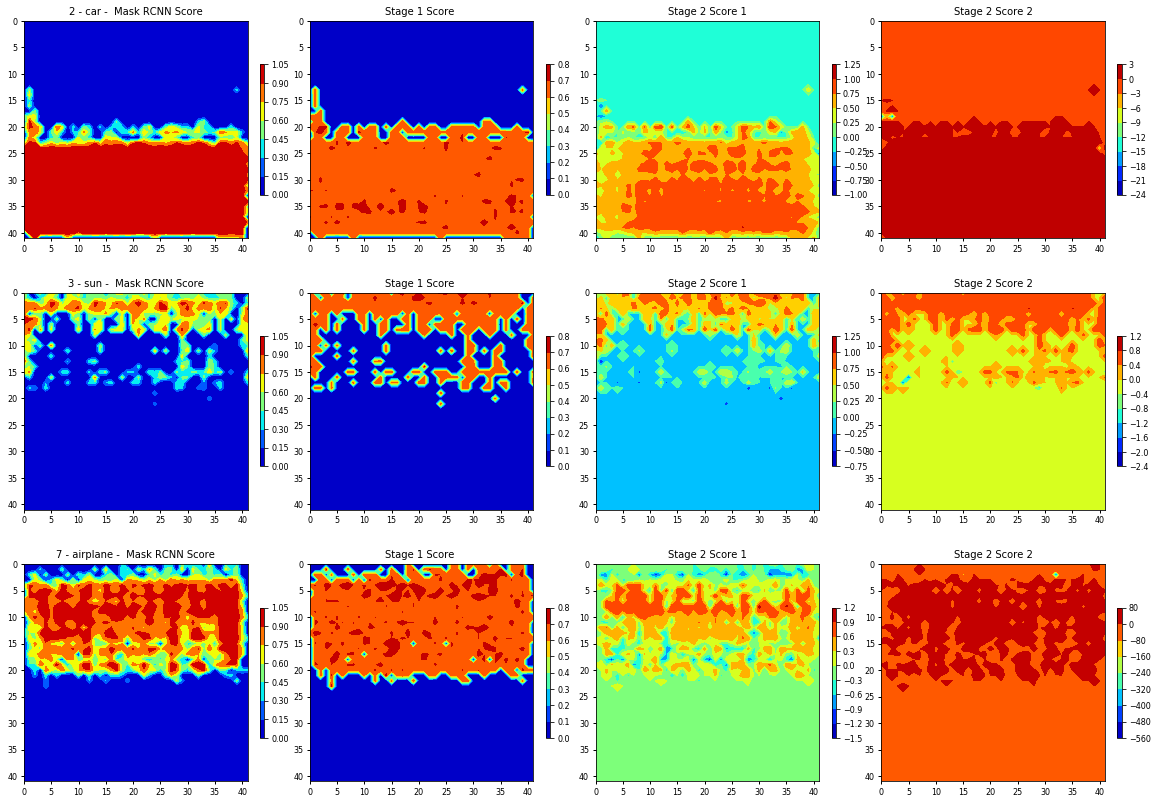

In [27]:
classes = [1,2,3,4,5,6,7,8]
classes = [2,3,5,7]
classes = [2,3,7]
print(load_file)
# _ =vis2.display_score_contours_compare(pr_scores, fcn_scores, class_names,  classes = classes)
_ =vis2.display_score_contours_compare(pr_scores, fcn_scores, class_names,  classes = classes, orig_scores = orig_scores)

(9, 1, 1)
 Num features:  8 Rows / Columns:  1 8


../mrcnn/visualize_2.py:945: RuntimeWarning: invalid value encountered in true_divide
  out /= (x.max(axis=(1,2), keepdims = True) - x.min(axis=(1,2), keepdims = True))


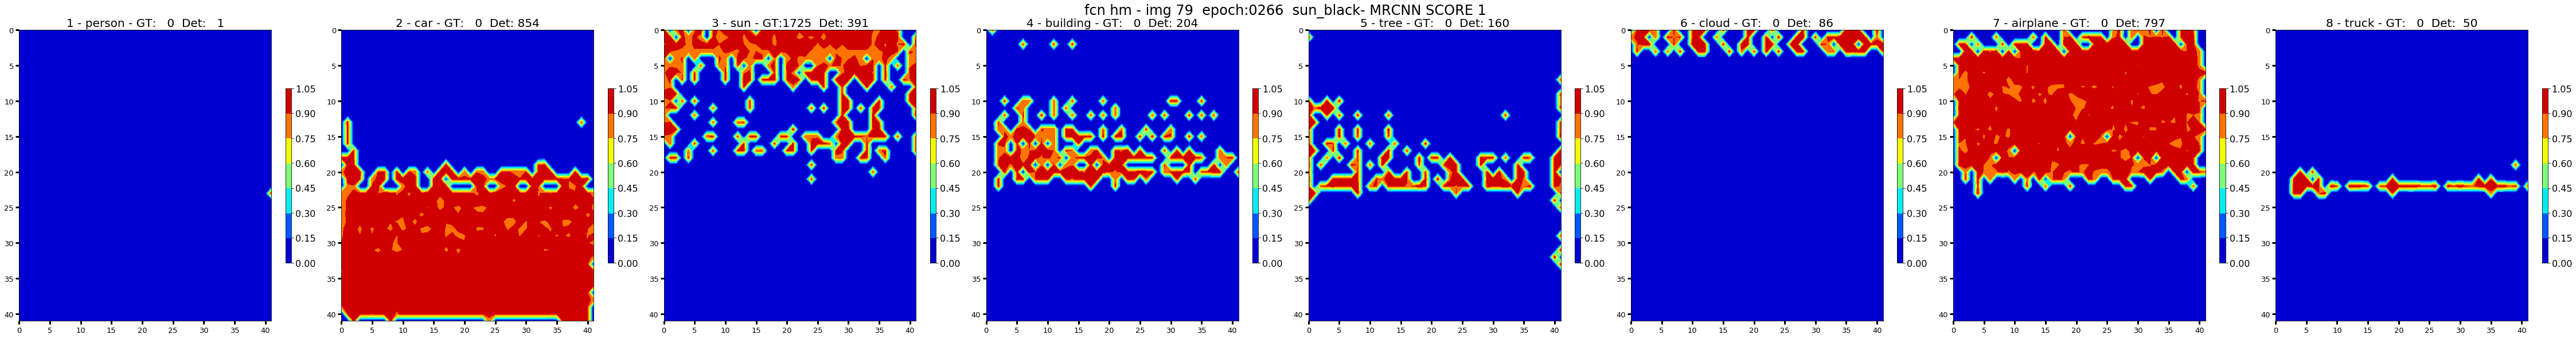

(9, 1, 1)
 Num features:  8 Rows / Columns:  1 8


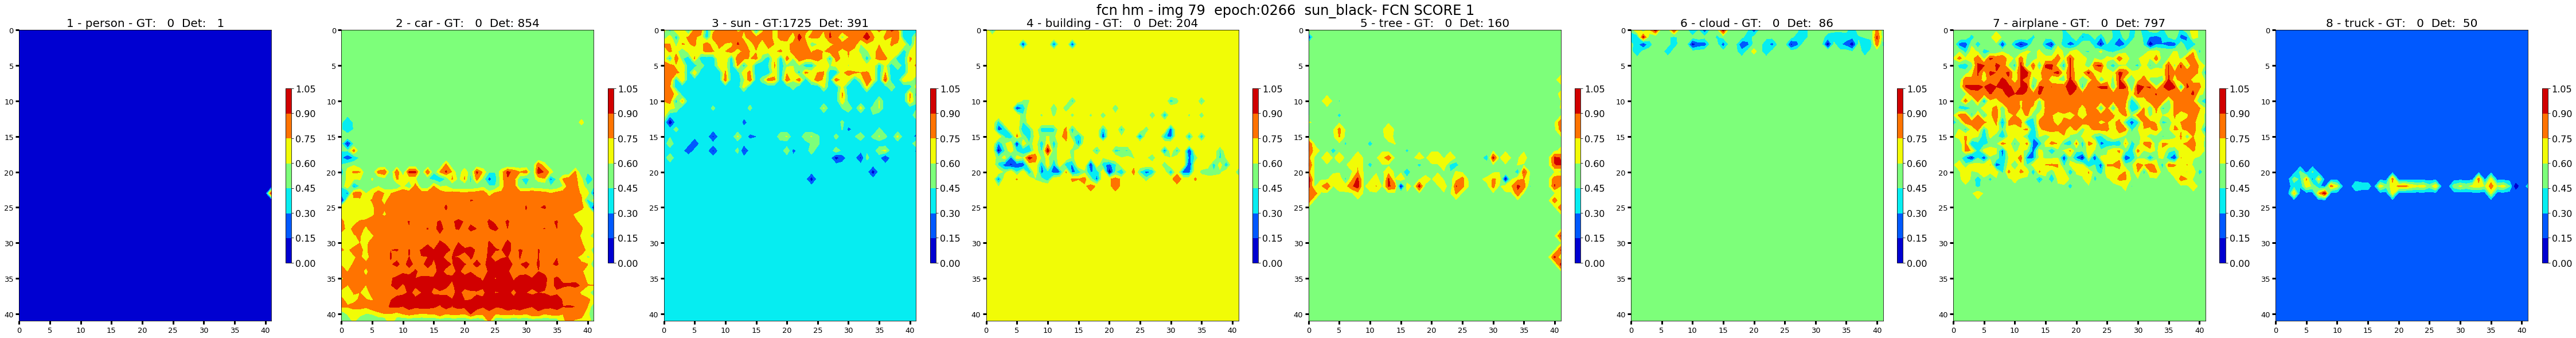

(9, 1, 1)
 Num features:  8 Rows / Columns:  1 8


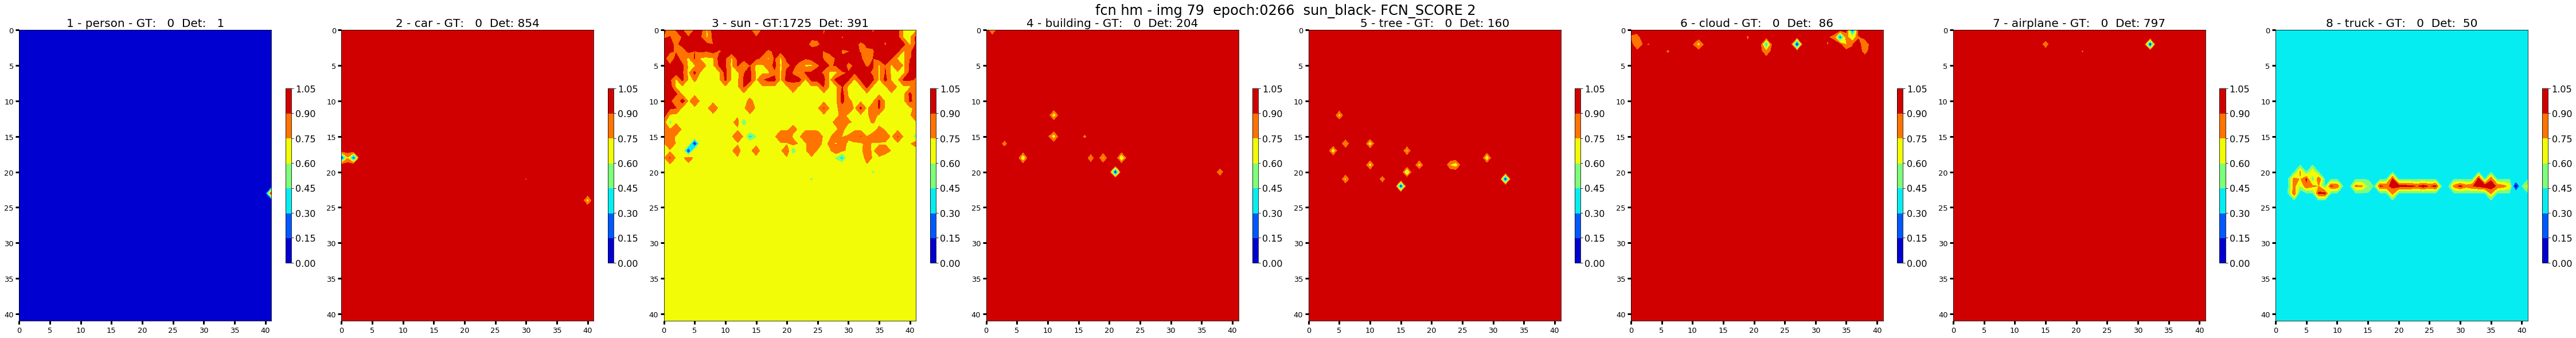

In [71]:
# print(ttl, cols)
# # classes = [1,2,3,4,5,6,7,8],2, keepdims=True
# classes = [2,3,4,6,7,8]

# print(results['fcn_scores'][1].shape, p1.shape)
# p1 = np.linalg.norm(results['pr_scores'][0],1, axis = (1,2), keepdims=True)
_ =vis2.display_score_contours(vis2.normalize_fcn_score(pr_scores[0]) , gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- MRCNN SCORE 1 ', classes = classes)
# _ =vis2.display_score_contours(results['pr_scores'][0]/p1 , gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- MRCNN SCORE 1 ', classes = classes)

# p1 = np.linalg.norm(results['fcn_scores'][0],1, axis = (1,2), keepdims=True)
_ =vis2.display_score_contours(vis2.normalize_fcn_score(fcn_scores[0]), gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- FCN SCORE 1 ', classes = classes)
# _ =vis2.display_score_contours(results['fcn_scores'][0]/p1, gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- FCN SCORE 1 ', classes = classes)


# p1 = np.linalg.norm(results['fcn_scores'][1],1, axis = (1,2), keepdims=True)
_ =vis2.display_score_contours(vis2.normalize_fcn_score(fcn_scores[1]), gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- FCN_SCORE 2 ', classes = classes)
# _ =vis2.display_score_contours(results['fcn_scores'][1]/p1, gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- FCN_SCORE 2 ', classes = classes)

### Cloud 

In [97]:
MRCNN_FILE_IDX = 1
exp_desc = 'cloud'
epochs = fcn_files[FILE_IDX].split('_')[1].replace('.h5','')
mrcnn_epochs = mrcnn_files[MRCNN_FILE_IDX].split('_')[1].replace('.h5','')
load_file =  exp_prfx+'_i'+str(image_id)+'_e'+epochs+'_m'+mrcnn_epochs+'_'+exp_desc+'.npz'
print(' LOAD FILENAME:', load_file)

filename  = os.path.join(save_path, load_file)

if os.path.exists(filename):
    print('  input file: ', filename)
    loaddata = np.load(os.path.join(save_path, load_file))

    pr_agg_hm         = loaddata['fcn_agg_hm']
    pr_agg_hm_clipped = loaddata['pr_agg_hm_clipped']
    fcn_agg_hm         = loaddata['fcn_agg_hm']
    fcn_agg_hm_clipped = loaddata['fcn_agg_hm_clipped']
    gt_cls_counts      = loaddata['gt_cls_counts']  
    dt_cls_counts      = loaddata['dt_cls_counts']      
    if 'orig_scores' in loaddata:
        print(' orig_scores exists')
        orig_scores         = loaddata['orig_scores']
    else:
        print('  orig scores doesn''t exist ')
    fcn_scores         = loaddata['fcn_scores']
    pr_scores          = loaddata['pr_scores']
else: 
    print(' file not found ', filename)

ttl = 'fcn hm - img '+str(image_id)+'  epoch:'+str(epochs) +'  '+ exp_desc 

 LOAD FILENAME: exp6_i79_e0266_m0020_cloud.npz
  input file:  /home/kbardool/git_projs/mrcnn3/train_newshapes_2/other/exp6_i79_e0266_m0020_cloud.npz
 orig_scores exists


exp6_i79_e0266_m0020_cloud.npz
 Num features:  8 Rows / Columns:  1 8


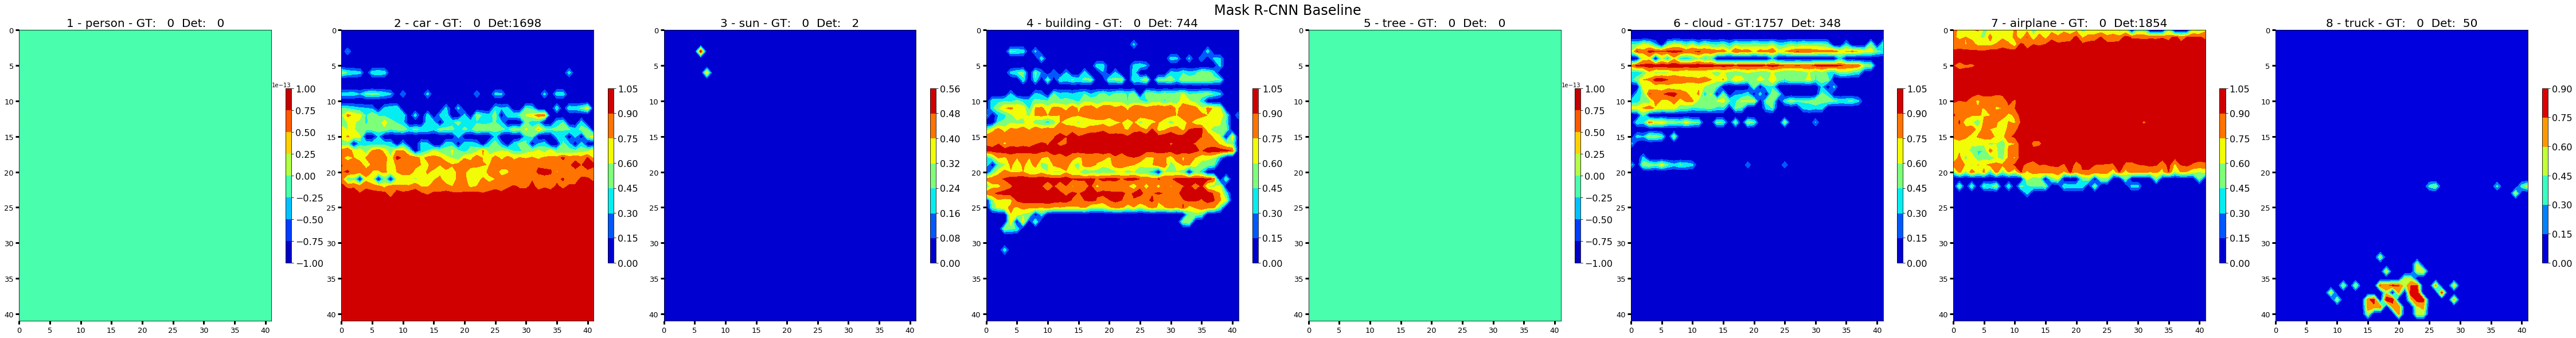

 Num features:  8 Rows / Columns:  1 8


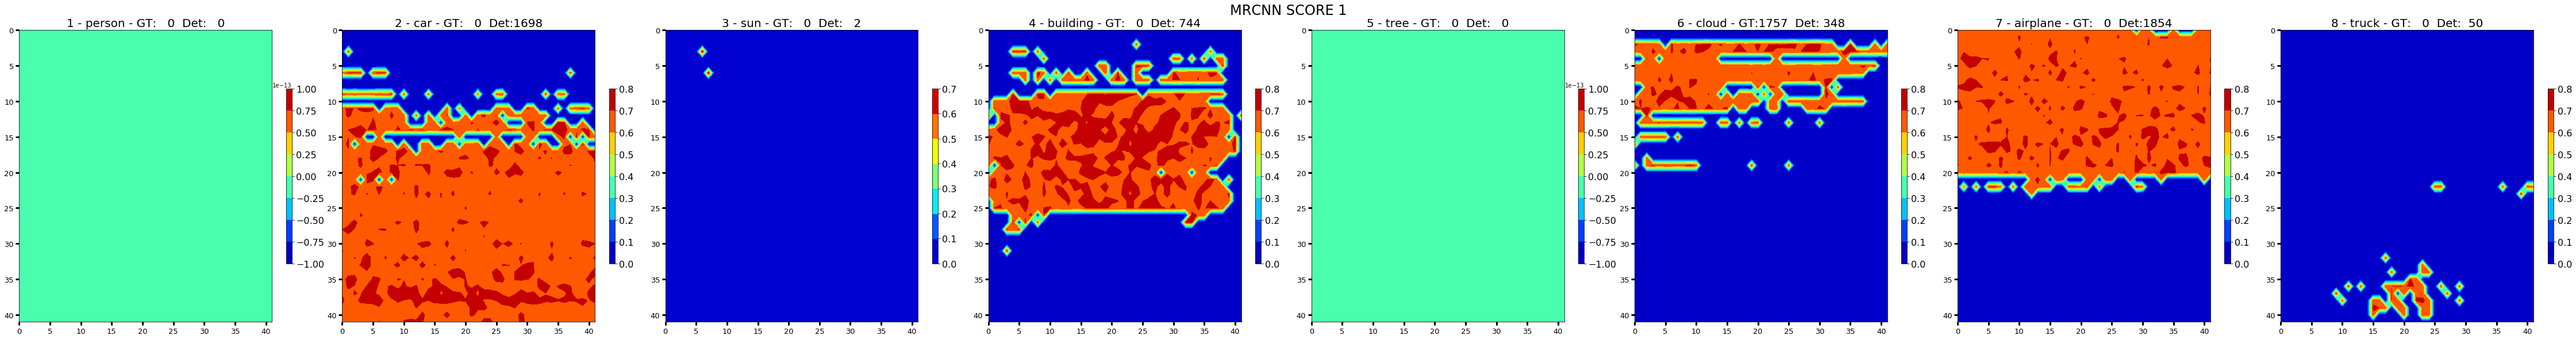

 Num features:  8 Rows / Columns:  1 8


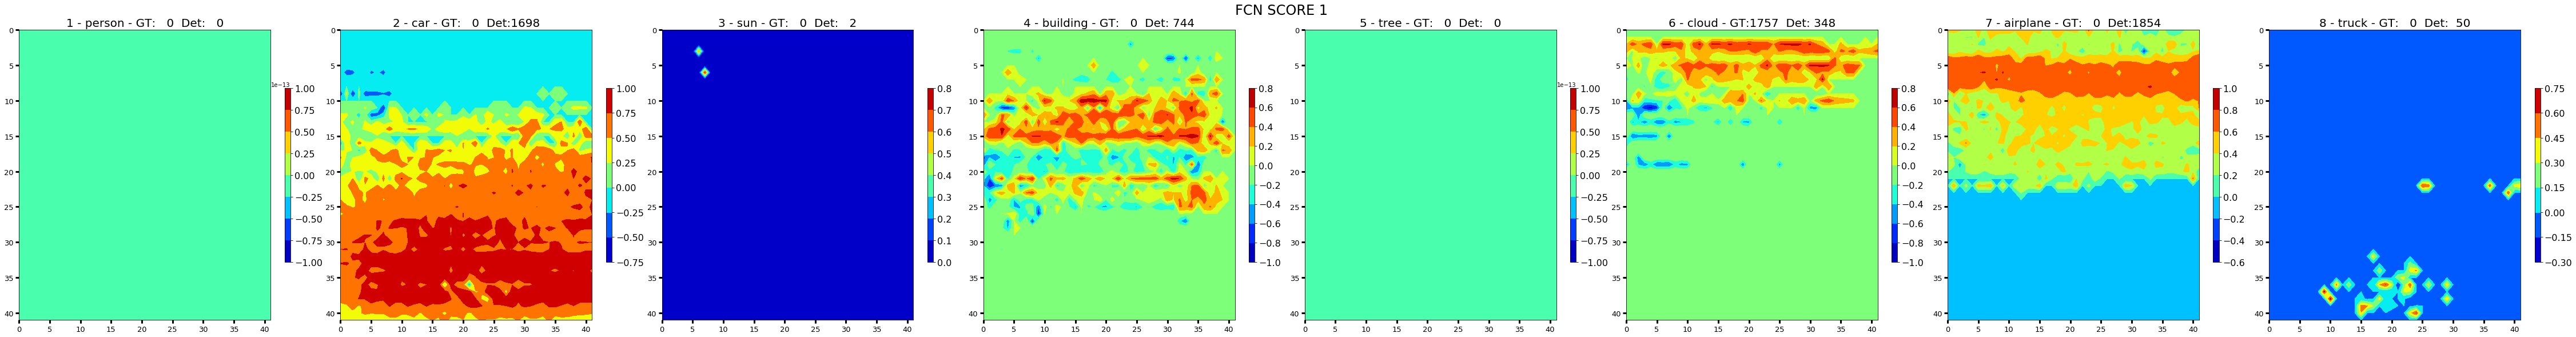

 Num features:  8 Rows / Columns:  1 8


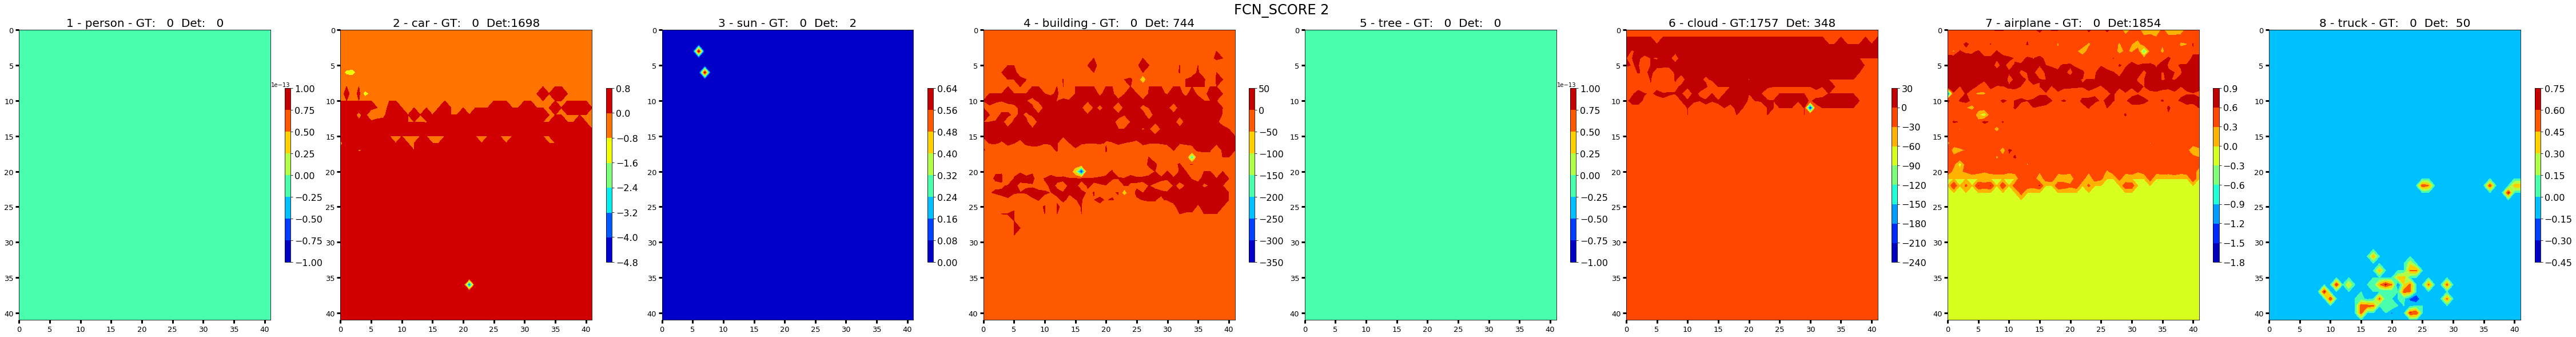

In [98]:
classes = [1,2,3,4,5,6,7,8]
# classes = [1,3,4,5,6,7]
# classes = [2,3,5,7,8]

print(load_file)
_ =vis2.display_score_contours(orig_scores[0]  , gt_cls_counts, dt_cls_counts, class_names, title ='Mask R-CNN Baseline', classes = classes)
_ =vis2.display_score_contours(pr_scores[0]  , gt_cls_counts, dt_cls_counts, class_names, title ='MRCNN SCORE 1 ', classes = classes)
_ =vis2.display_score_contours(fcn_scores[0], gt_cls_counts, dt_cls_counts, class_names, title = 'FCN SCORE 1 ', classes = classes)
_ =vis2.display_score_contours(fcn_scores[1], gt_cls_counts, dt_cls_counts, class_names, title = 'FCN_SCORE 2 ', classes = classes)

In [95]:
exp_desc = 'cloud'
epochs = fcn_files[FILE_IDX].split('_')[1].replace('.h5','')
mrcnn_epochs = mrcnn_files[MRCNN_FILE_IDX].split('_')[1].replace('.h5','')
load_file =  exp_prfx+'_i'+str(image_id)+'_e'+epochs+'_m'+mrcnn_epochs+'_'+exp_desc+'.npz'
print(' LOAD FILENAME:', load_file)

filename  = os.path.join(save_path, load_file)

if os.path.exists(filename):
    print('  input file: ', filename)
    loaddata = np.load(os.path.join(save_path, load_file))

    pr_agg_hm         = loaddata['fcn_agg_hm']
    pr_agg_hm_clipped = loaddata['pr_agg_hm_clipped']
    fcn_agg_hm         = loaddata['fcn_agg_hm']
    fcn_agg_hm_clipped = loaddata['fcn_agg_hm_clipped']
    gt_cls_counts      = loaddata['gt_cls_counts']  
    dt_cls_counts      = loaddata['dt_cls_counts']      
    if 'orig_scores' in loaddata:
        print(' orig_scores exists')
        orig_scores         = loaddata['orig_scores']
    else:
        print('  orig scores doesn''t exist ')
    fcn_scores         = loaddata['fcn_scores']
    pr_scores          = loaddata['pr_scores']
else: 
    print(' file not found ', filename)

ttl = 'fcn hm - img '+str(image_id)+'  epoch:'+str(epochs) +'  '+ exp_desc 

 LOAD FILENAME: exp6_i79_e0266_m0243_cloud.npz
  input file:  /home/kbardool/git_projs/mrcnn3/train_newshapes_2/other/exp6_i79_e0266_m0243_cloud.npz
 orig_scores exists


exp6_i79_e0266_m0243_cloud.npz
 Num features:  8 Rows / Columns:  1 8


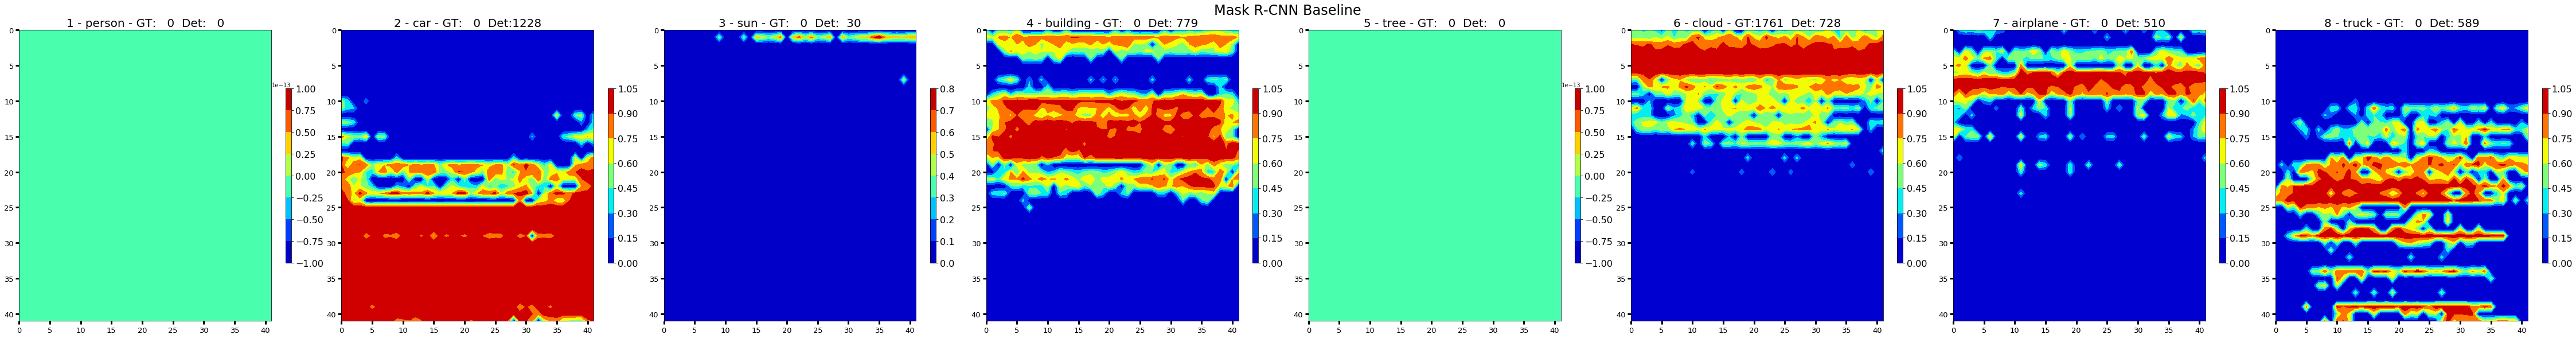

 Num features:  8 Rows / Columns:  1 8


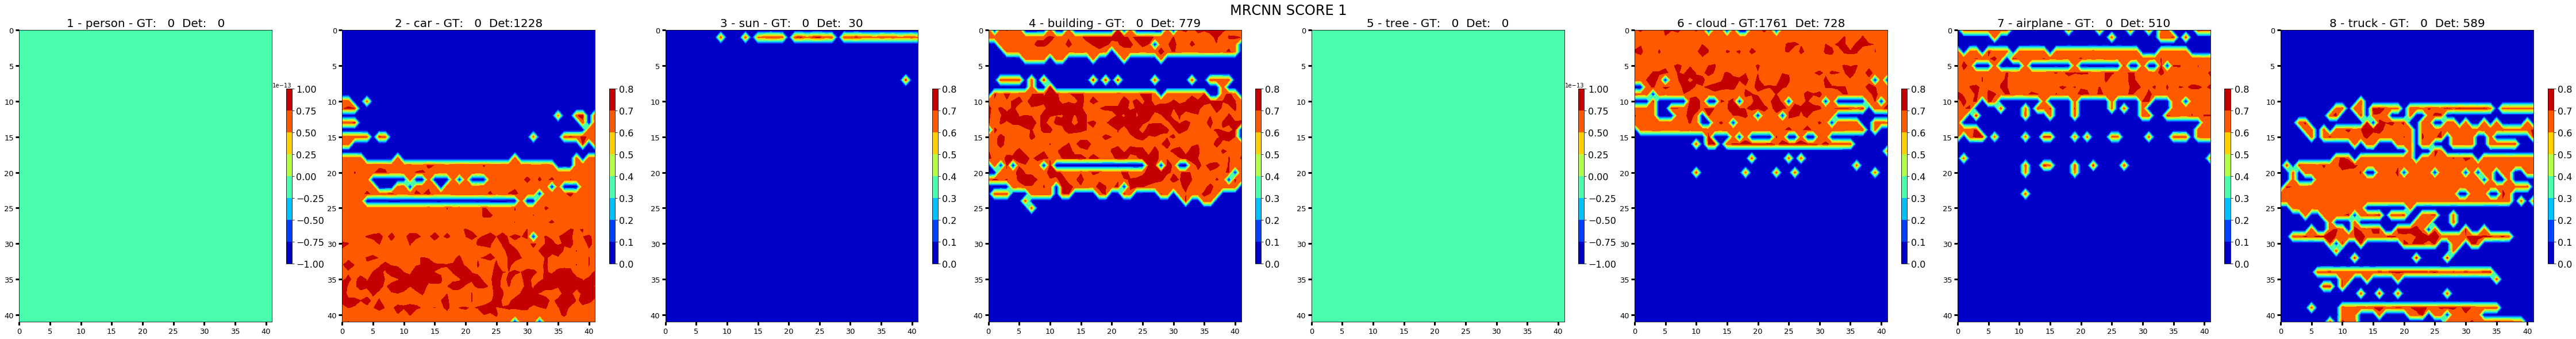

 Num features:  8 Rows / Columns:  1 8


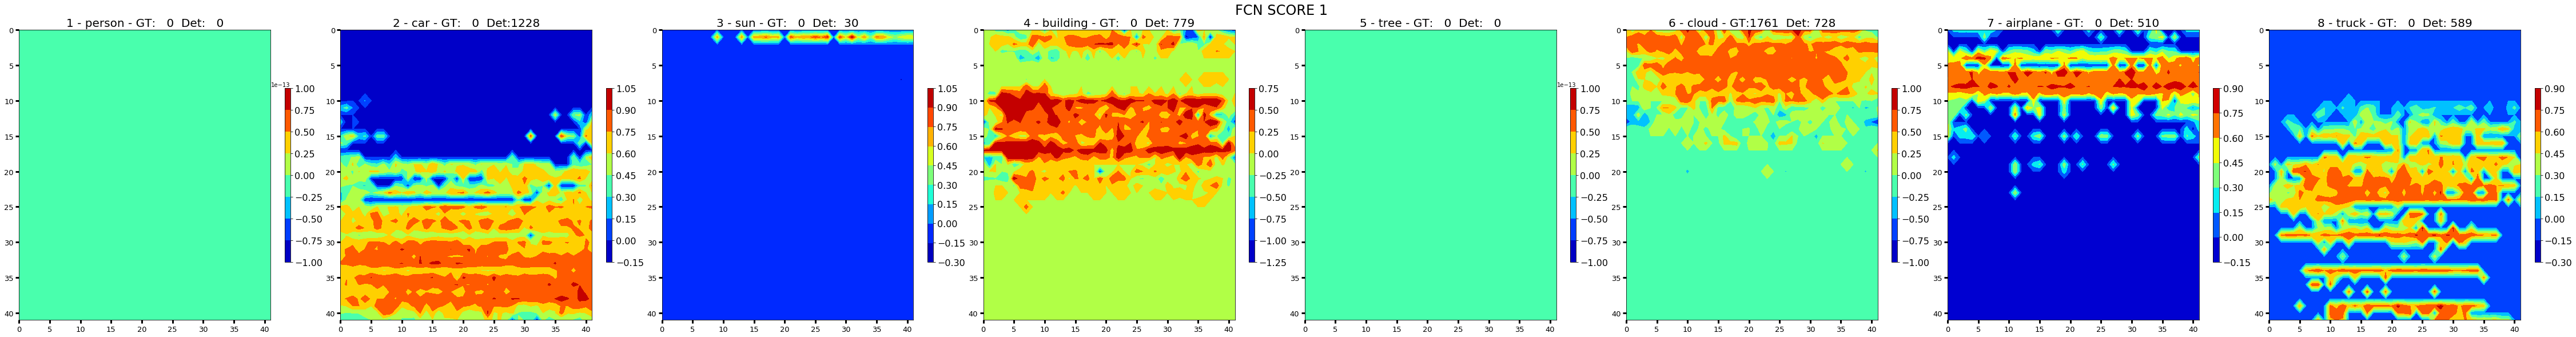

 Num features:  8 Rows / Columns:  1 8


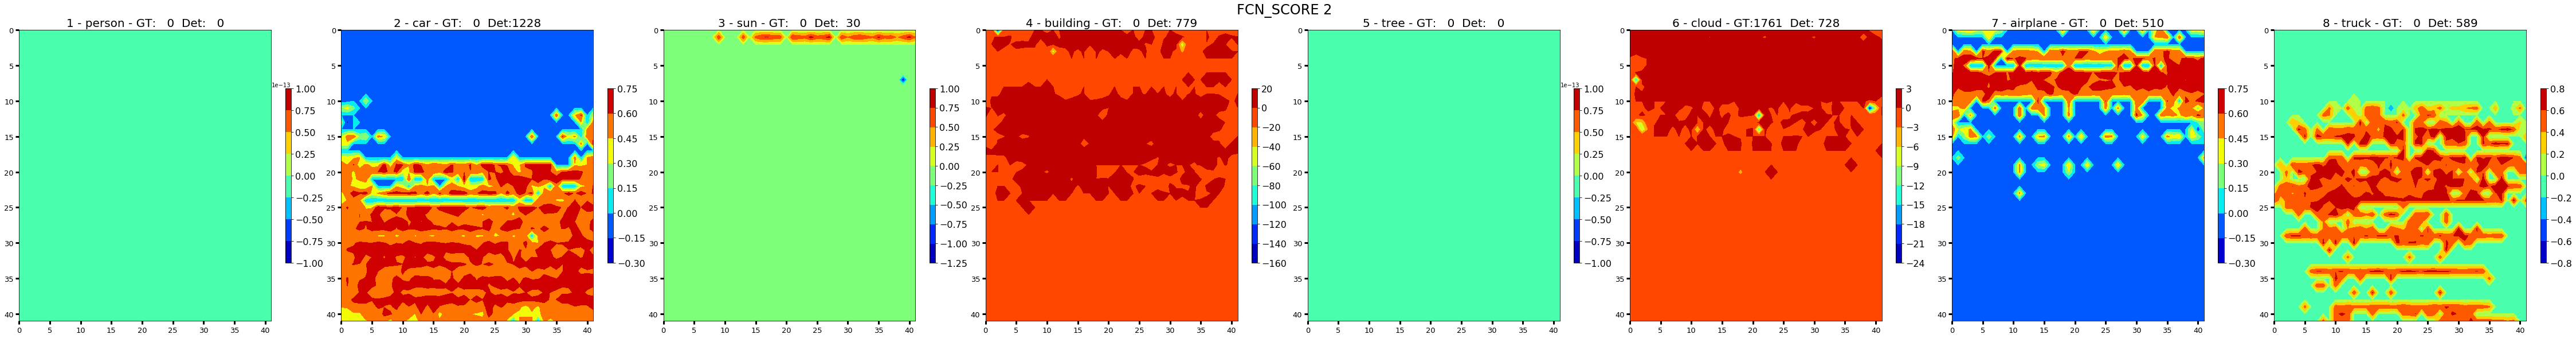

In [96]:
# print(ttl, cols)
classes = [1,2,3,4,5,6,7,8]
# classes = [1,3,4,5,6,7]
# classes = [2,3,5,7,8]

print(load_file)
_ =vis2.display_score_contours(orig_scores[0]  , gt_cls_counts, dt_cls_counts, class_names, title ='Mask R-CNN Baseline', classes = classes)
_ =vis2.display_score_contours(pr_scores[0]  , gt_cls_counts, dt_cls_counts, class_names, title ='MRCNN SCORE 1 ', classes = classes)
_ =vis2.display_score_contours(fcn_scores[0], gt_cls_counts, dt_cls_counts, class_names, title = 'FCN SCORE 1 ', classes = classes)
_ =vis2.display_score_contours(fcn_scores[1], gt_cls_counts, dt_cls_counts, class_names, title = 'FCN_SCORE 2 ', classes = classes)

##  Display Aggregate Heatmaps

In [315]:
# classes = [2,3,4,6,7,8]
# # print(results['fcn_scores'][1].shape, p1.shape)
# p1 = np.linalg.norm(pr_scores[0],1, axis = (1,2), keepdims=True)
# _ =vis2.display_score_contours(pr_scores[0]/p1 , gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- MRCNN SCORE 1 ', classes = classes)
# p1 = np.linalg.norm(fcn_scores[0],1, axis = (1,2), keepdims=True)
# _ =vis2.display_score_contours(fcn_scores[0]/p1, gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- FCN SCORE 1 ', classes = classes)
# p1 = np.linalg.norm(fcn_scores[1],1, axis = (1,2), keepdims=True)
# _ =vis2.display_score_contours(fcn_scores[1]/p1, gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- FCN_SCORE 2 ', classes = classes)

exp6_i79_e0266_m0243_sun_black.npz
 Num features:  [2, 3, 6, 7] Rows / Columns:  1 4 classes :  [2, 3, 6, 7]


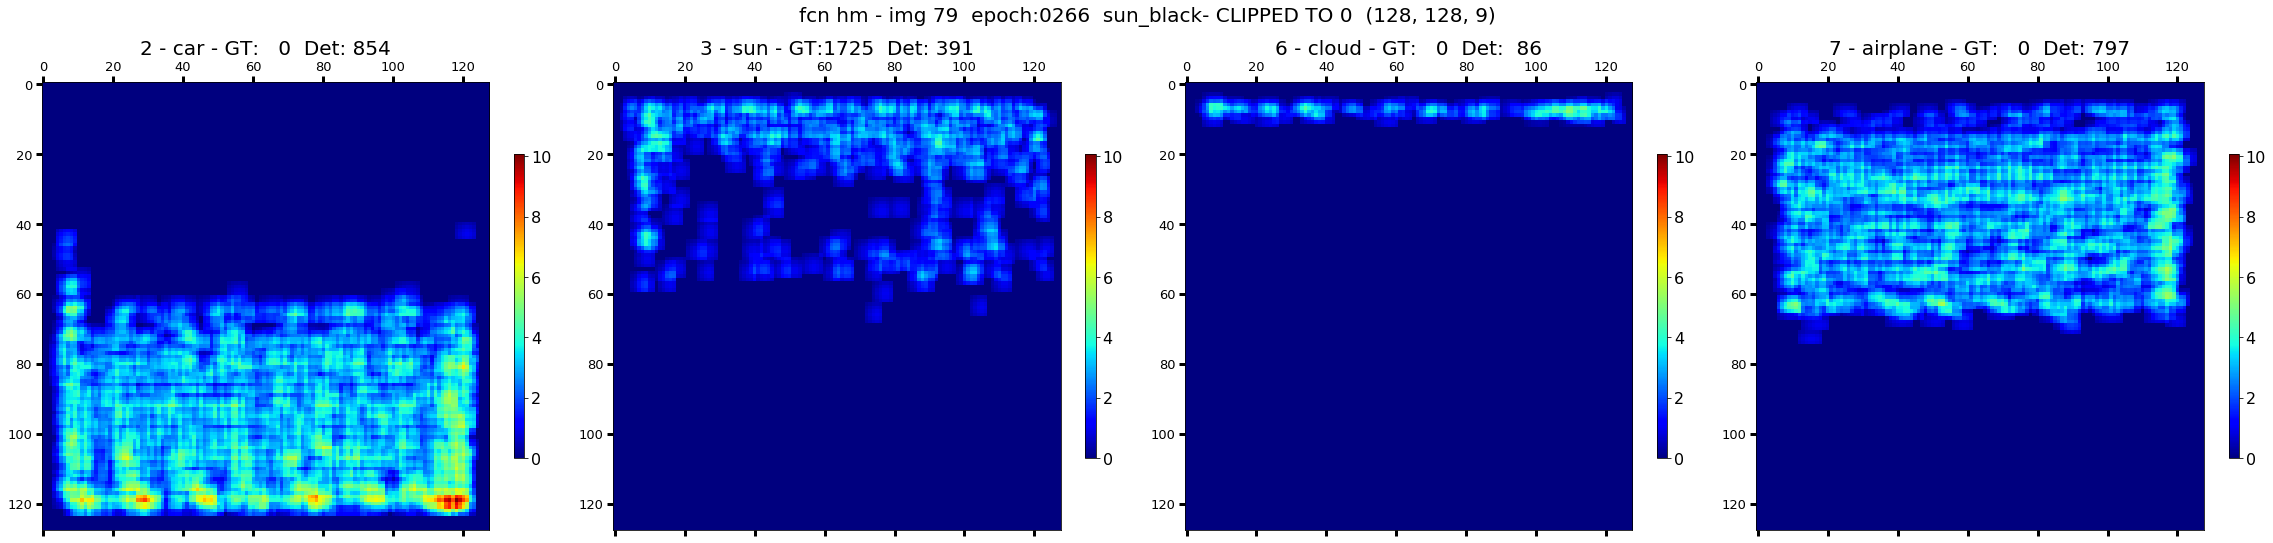

 Num features:  [2, 3, 6, 7] Rows / Columns:  1 4 classes :  [2, 3, 6, 7]


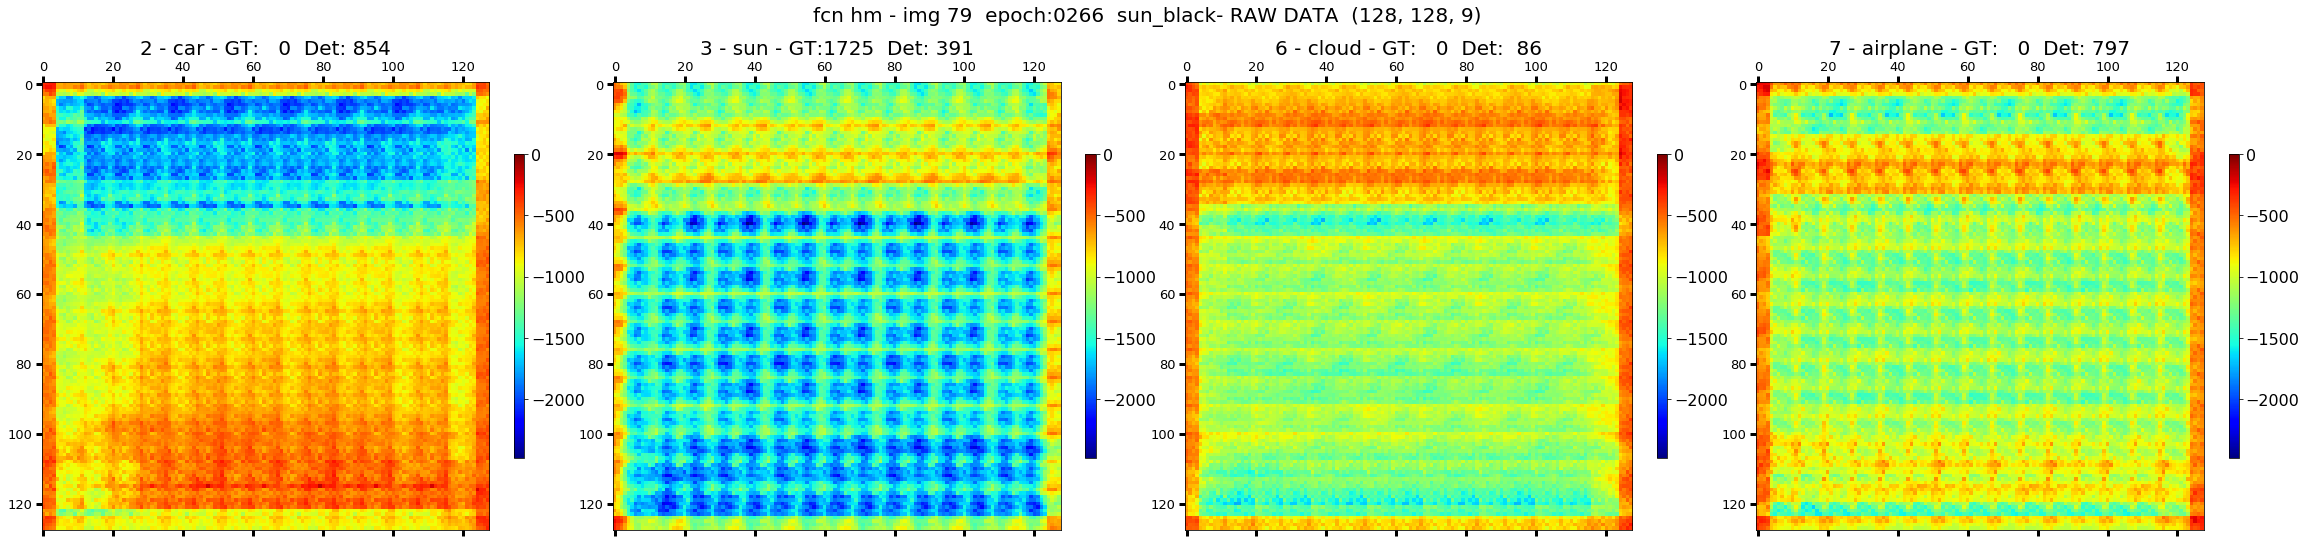

(128, 128, 9)
 Num features:  [2, 3, 6, 7] Rows / Columns:  1 4 classes :  [2, 3, 6, 7]


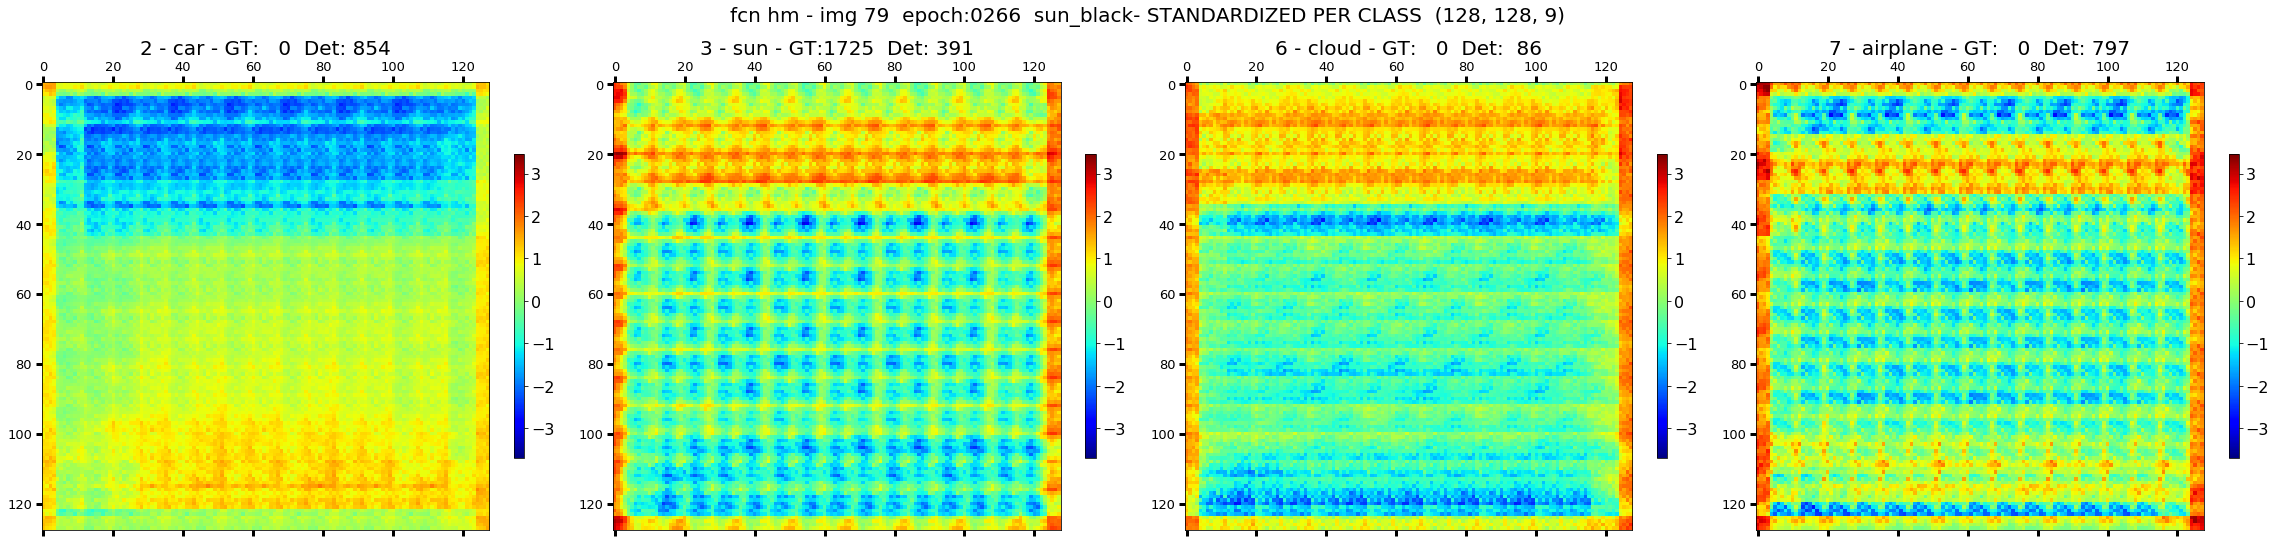

 Num features:  [2, 3, 6, 7] Rows / Columns:  1 4 classes :  [2, 3, 6, 7]


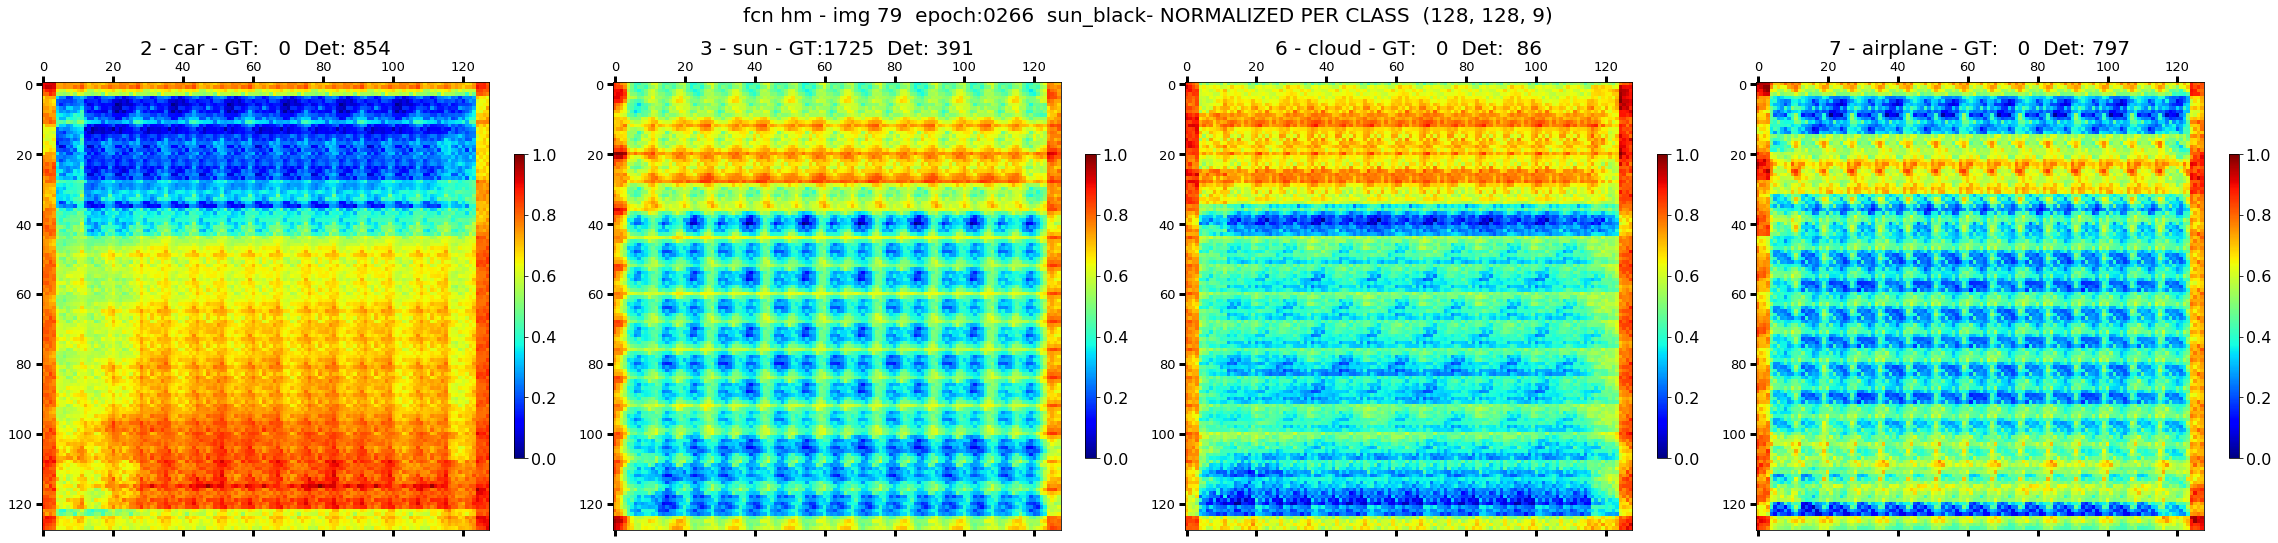

 Num features:  [2, 3, 6, 7] Rows / Columns:  1 4 classes :  [2, 3, 6, 7]


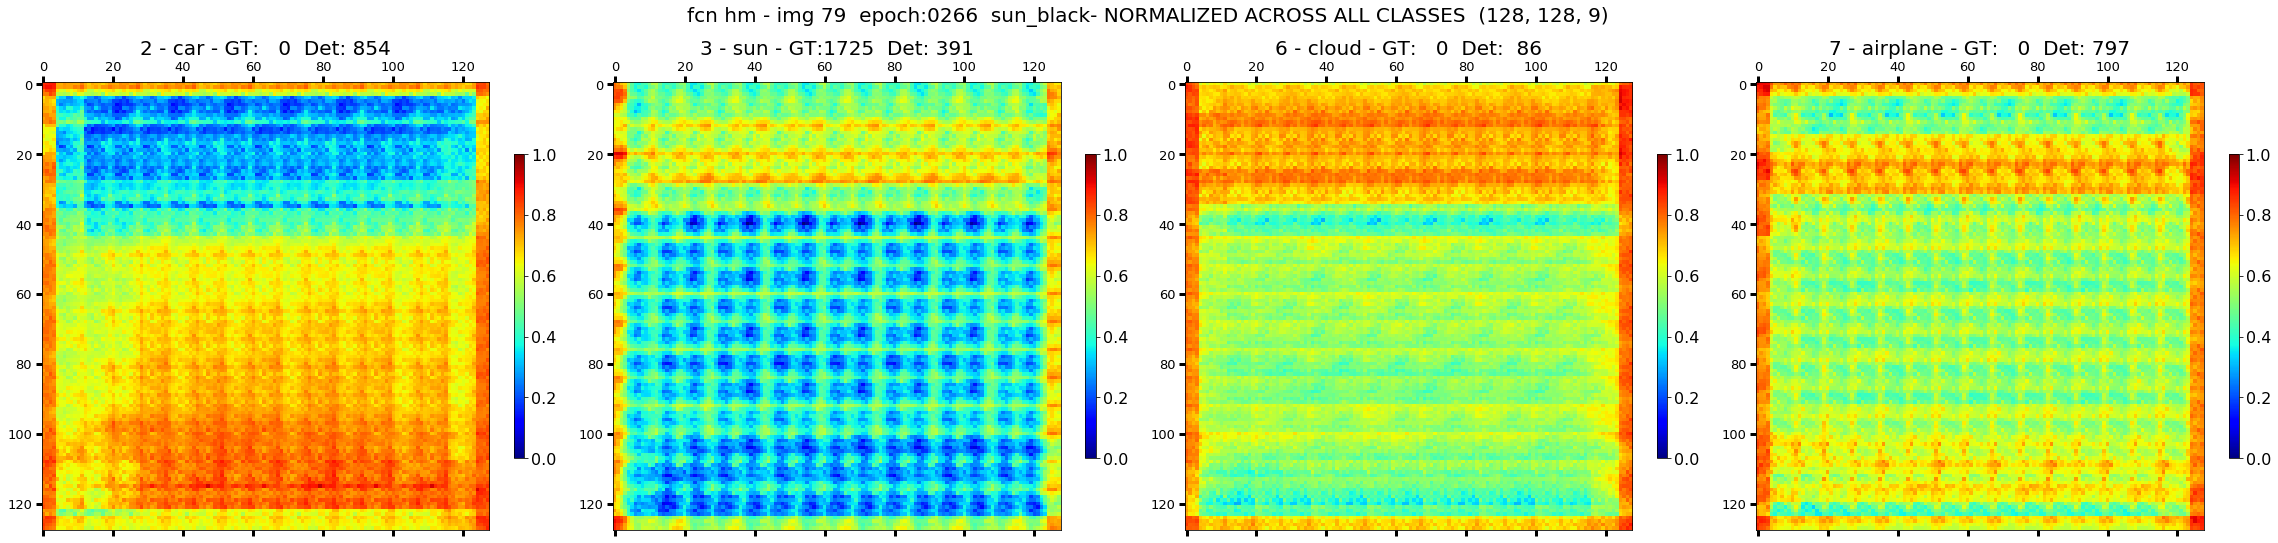

In [94]:
classes = [1,2,3,4,5,6,7,8]
classes = [2,3,6,7]
print(load_file)
_ =vis2.display_fcn_agg_heatmaps(pr_agg_hm_clipped, gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- CLIPPED TO 0 ', classes = classes)
_ =vis2.display_fcn_agg_heatmaps(pr_agg_hm, gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- RAW DATA ', norm = False, classes = classes)
# vis2.display_fcn_agg_heatmaps(vis2.deprocess_image(pr_agg_hm), gt_cls_counts, dt_cls_counts, class_names, columns = cols, title = ttl +'- DEPROCESSED ', classes = classes)
_ =vis2.display_fcn_agg_heatmaps(vis2.standardize_fcn_hm(pr_agg_hm), gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- STANDARDIZED PER CLASS ', classes = classes)
_ =vis2.display_fcn_agg_heatmaps(vis2.normalize_fcn_hm(pr_agg_hm), gt_cls_counts, dt_cls_counts, class_names, title = ttl +'- NORMALIZED PER CLASS ', classes = classes)
_ = vis2.display_fcn_agg_heatmaps(vis2.normalize_all(pr_agg_hm), gt_cls_counts, dt_cls_counts, class_names,  title = ttl +'- NORMALIZED ACROSS ALL CLASSES ', classes = classes)

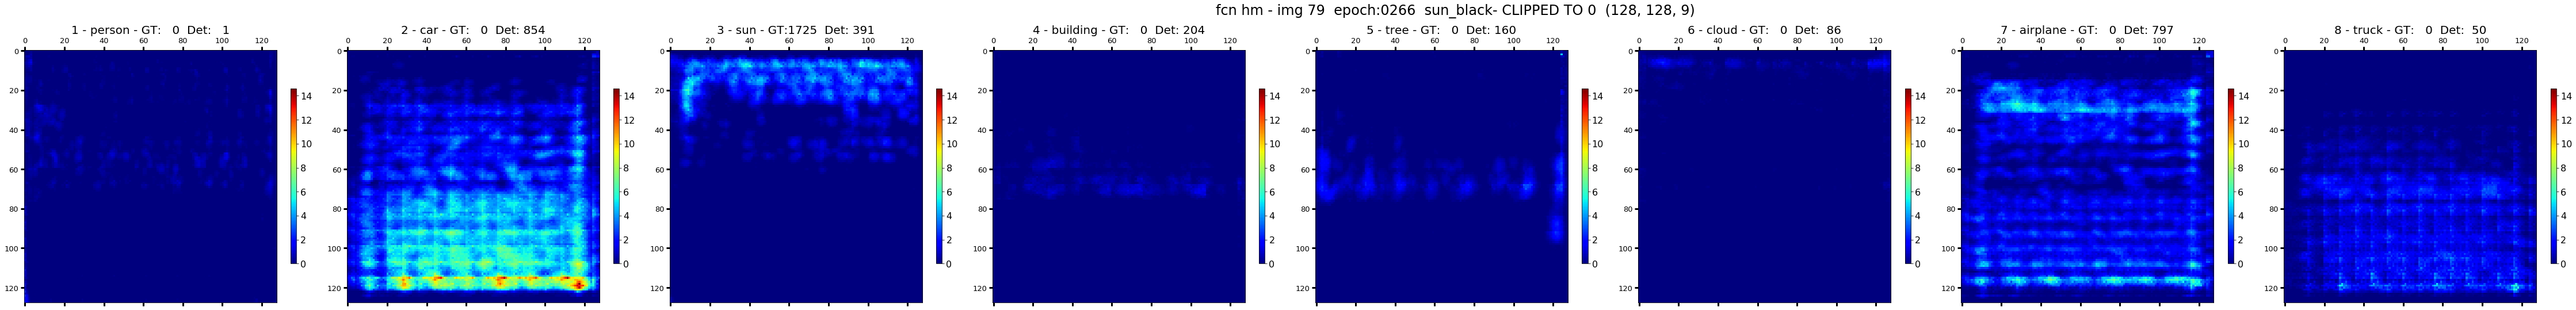

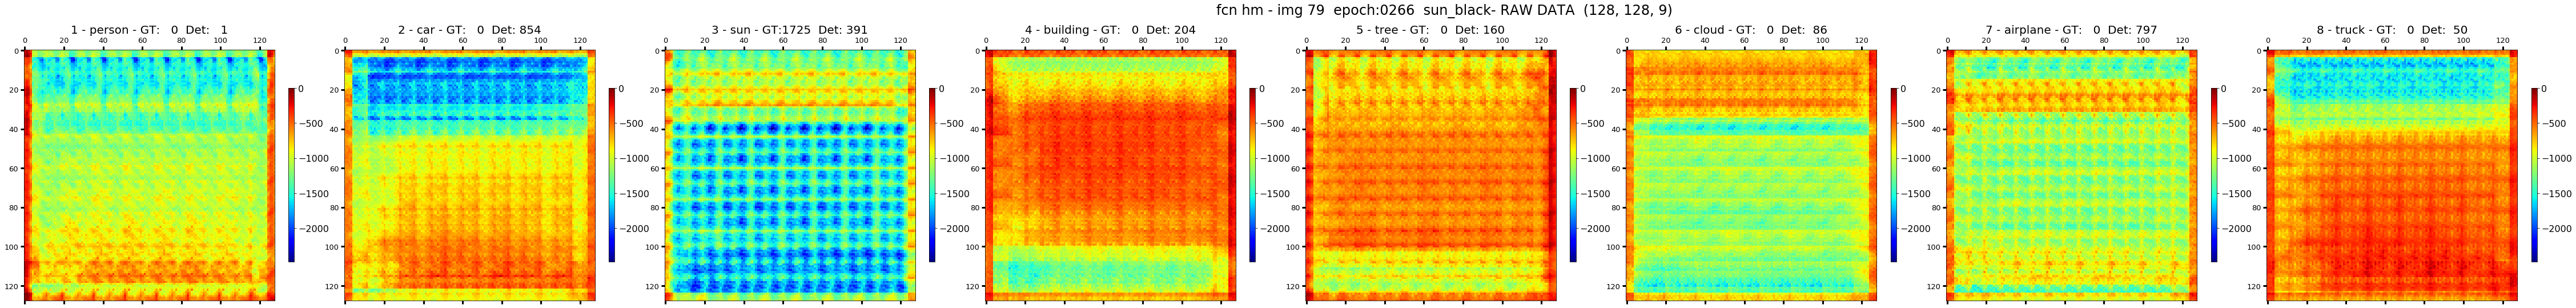

(128, 128, 9)


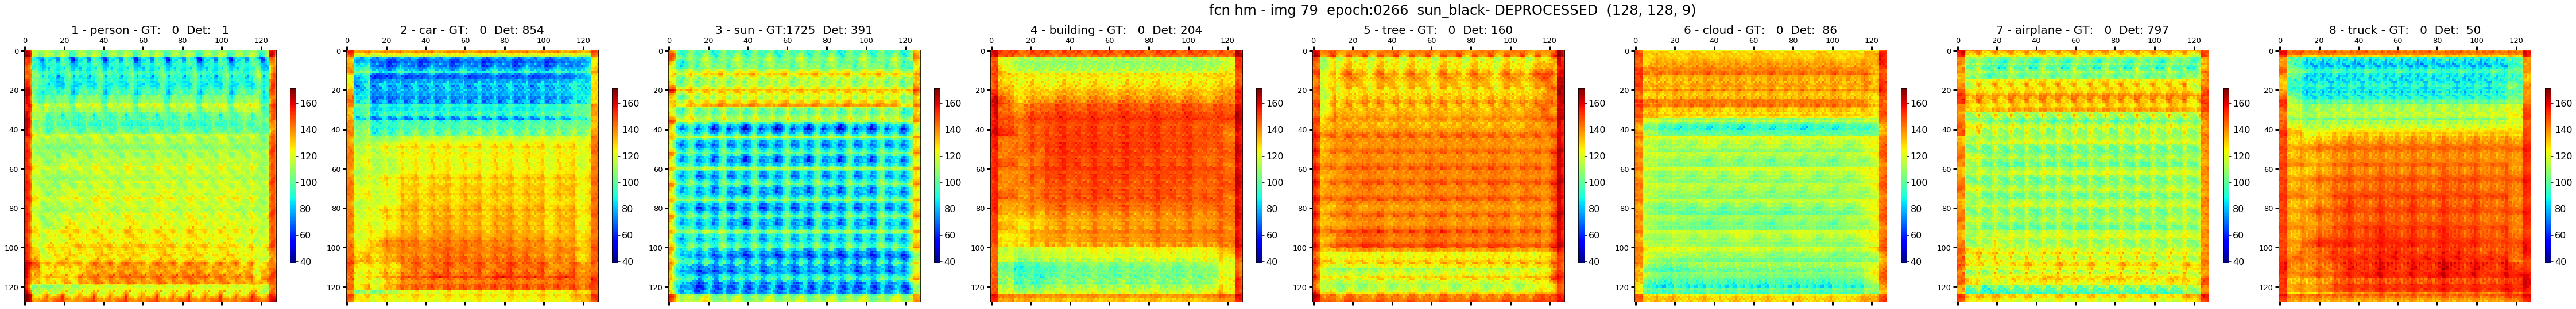

(128, 128, 9)


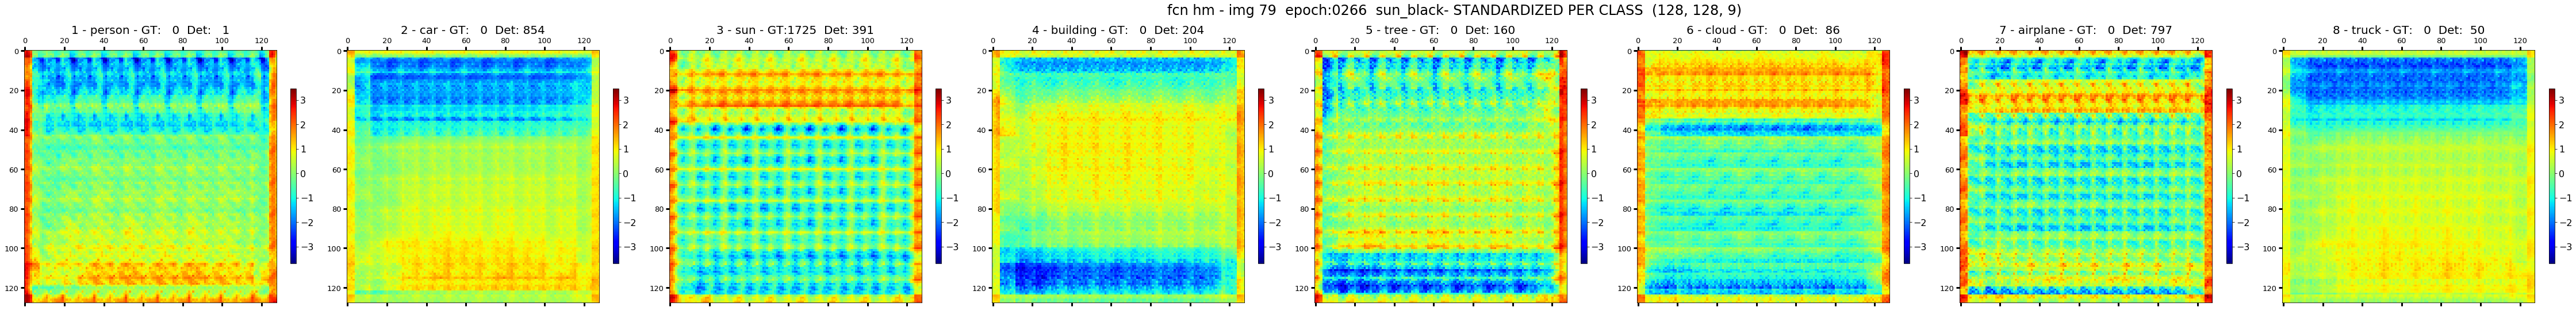

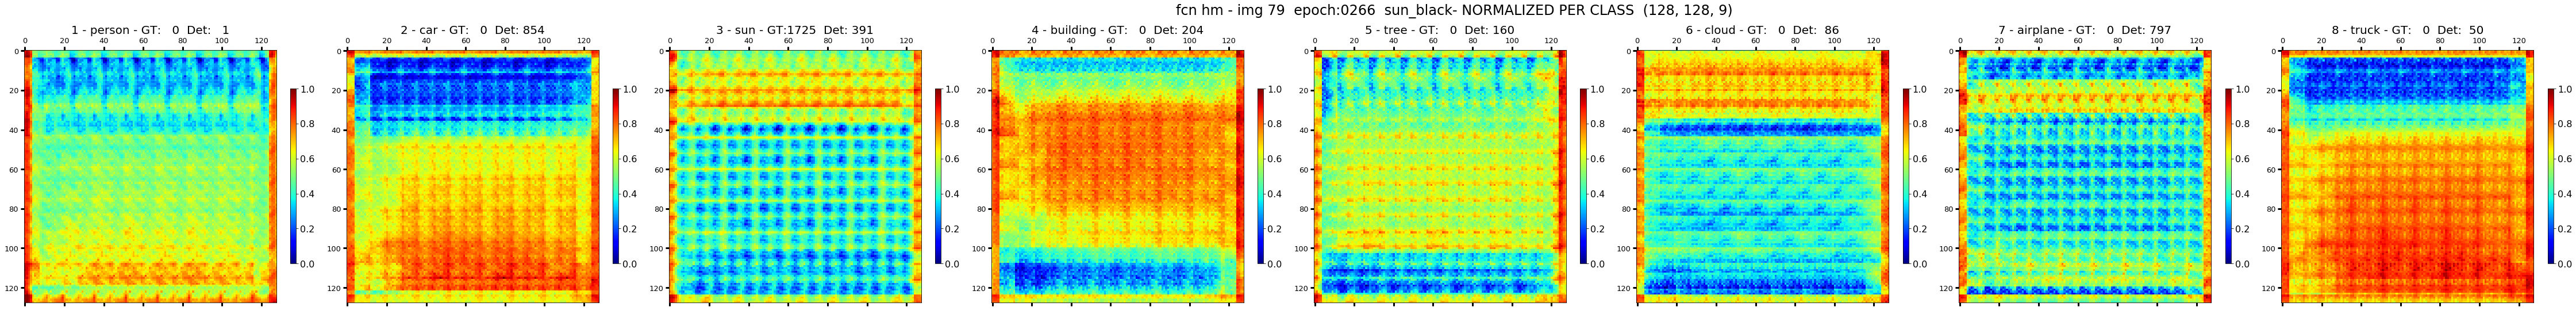

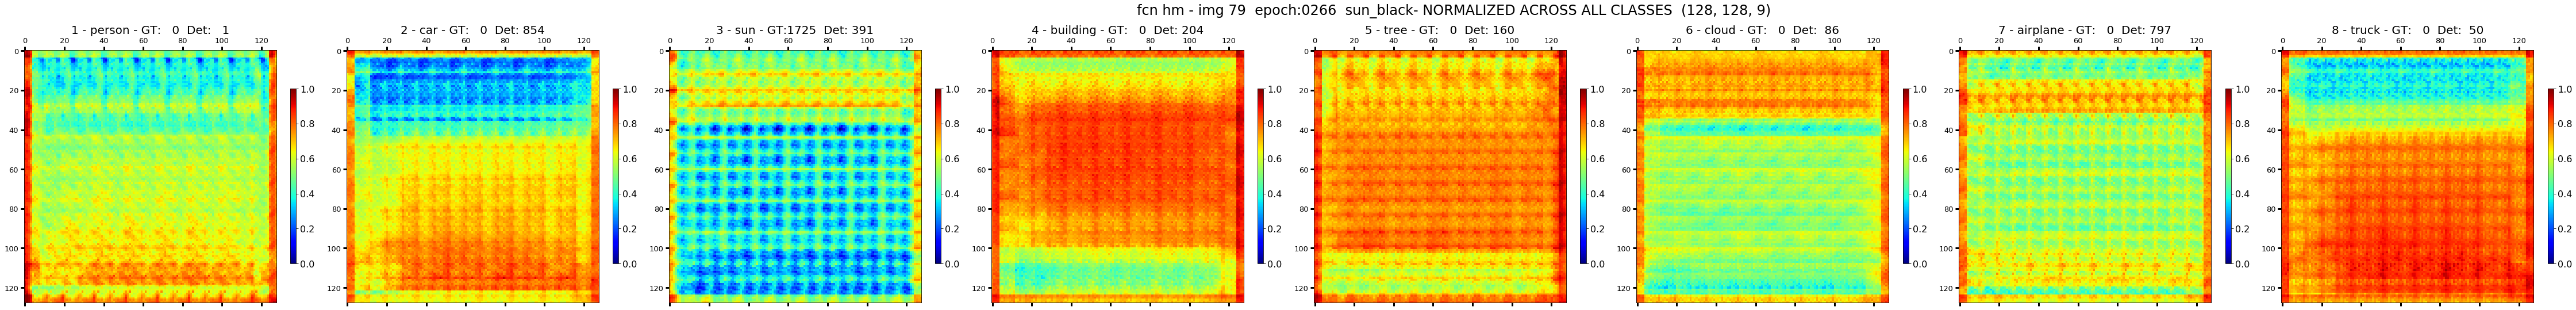

In [70]:
classes = [1,2,3,4,5,6,7,8]

_ =vis2.display_fcn_agg_heatmaps(fcn_agg_hm_clipped, gt_cls_counts, dt_cls_counts, class_names, columns =cols, title = ttl +'- CLIPPED TO 0 ', classes = classes)
_ =vis2.display_fcn_agg_heatmaps(fcn_agg_hm, gt_cls_counts, dt_cls_counts, class_names, columns = cols, title = ttl +'- RAW DATA ', norm = False, classes = classes)
_ =vis2.display_fcn_agg_heatmaps(vis2.deprocess_image(fcn_agg_hm), gt_cls_counts, dt_cls_counts, class_names, columns = cols, title = ttl +'- DEPROCESSED ', classes = classes)
_ =vis2.display_fcn_agg_heatmaps(vis2.standardize_fcn_hm(fcn_agg_hm), gt_cls_counts, dt_cls_counts, class_names, columns = cols, title = ttl +'- STANDARDIZED PER CLASS ', classes = classes)
_ =vis2.display_fcn_agg_heatmaps(vis2.normalize_fcn_hm(fcn_agg_hm), gt_cls_counts, dt_cls_counts, class_names, columns = cols, title = ttl +'- NORMALIZED PER CLASS ', classes = classes)
_ =vis2.display_fcn_agg_heatmaps(vis2.normalize_all(fcn_agg_hm), gt_cls_counts, dt_cls_counts, class_names, columns = cols, title = ttl +'- NORMALIZED ACROSS ALL CLASSES ', classes = classes)

In [ ]:
delta = fcn_agg_hm_clipped - pr_agg_hm_clipped
vis2.display_fcn_agg_heatmaps(delta, gt_cls_counts, dt_cls_counts, class_names, columns =cols, title = ttl +'- CLIPPED TO 0 ', classes = classes)

In [ ]:
print(fcn_agg_hm.min(axis=(0,1), keepdims = True))
print(fcn_agg_hm.min( keepdims = True))


## Load and Display saved .npz file 

In [ ]:
# epochs = files[FILE_IDX].split('_')[1].replace('.h5','')
epochs = '0266'
image_id =  176
load_file =  'exp2_img'+'_'+str(image_id)+'_epoch_'+epochs+'.npz'
print('  input file: ',os.path.join(save_path, load_file))

In [ ]:
loaddata = np.load(os.path.join(save_path, load_file))
# print(type(loaddata))
# print(loaddata.keys)
# print(type(loaddata['gt_ttl_img_by_inst']),'  ', type(loaddata['gt_ttl_img_by_inst'][0]))

gt_cls_counts      = loaddata['gt_cls_counts']  
dt_cls_counts      = loaddata['dt_cls_counts']  
# imgs_one_gt        = loaddata['imgs_one_gt']  
# imgs_one_dt        = loaddata['imgs_one_dt'] 
# gt_ttl_img_by_inst = loaddata['gt_ttl_img_by_inst']
# dt_ttl_img_by_inst = loaddata['dt_ttl_img_by_inst']
# sav_pr_min         = loaddata['sav_pr_min'] 
# sav_pr_max         = loaddata['sav_pr_max']  
# sav_fcn_min        = loaddata['sav_fcn_min']
# sav_fcn_max        = loaddata['sav_fcn_max']
pr_agg_hm          = loaddata['pr_agg_hm']
pr_agg_hm_clipped  = loaddata['pr_agg_hm_clipped']
fcn_agg_hm         = loaddata['fcn_agg_hm']
fcn_agg_hm_clipped = loaddata['fcn_agg_hm_clipped']

print('Agg heatmap Calcs complete for epoch:', epochs , ' (heatmap file:', load_file, ')')
# display_results(loaddata)

## Display Heatmaps

In [ ]:
# hmfig = vis2.display_pairwise_heatmap(gt_ttl_img_by_inst, [0,1,2,3,4,5,6,7,8], class_names)

### mask_rcnn output

In [ ]:
classes = [1,2,3,4,5,6,7,8]
vis2.display_fcn_input(pr_agg_hm, gt_cls_counts, dt_cls_counts, class_names, classes = classes, cmap = 'jet', columns = 7, title = 'rcnn heatmaps - NOT clipped ')
vis.plot_2d_gaussian(pr_agg_hm[:,:,1], size =(5,5), title = 'MRCNN produced heatmap')

### mask_rcnn output - normalized

In [ ]:
vis2.display_fcn_input_1(vis2.normalize_fcn_hm(pr_agg_hm), gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns = 7, title = 'rcnn heatmaps - NOT clipped ')
vis.plot_2d_gaussian(vis2.normalize_fcn_hm(pr_agg_hm[:,:,2]), size =(5,5))

In [ ]:
vis.display_image_gt(dataset_test, dataset_test.config, image_id , size = 5, verbose = False)   

### mask_rcnn output - standarize and clip

In [ ]:
vis2.display_fcn_input_1(vis2.standardize_fcn_hm(pr_agg_hm), gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns = 7, title = 'rcnn heatmaps - Standardized - ')
vis2.display_fcn_input_1(vis2.deprocess_image(pr_agg_hm), gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns = 7, title = 'rcnn heatmaps - NOT Clipped - Normalized - ')

###  mask_rcnn clipped  
(pr_agg_hm_clipped is same as pr_agg_hm since the ouptut of R-CNN is [0,1]

In [ ]:
vis2.display_fcn_input_1(pr_agg_hm_clipped, gt_cls_counts, dt_cls_counts, class_names , cmap = 'jet', columns = 7, title = 'rcnn heatmaps - clipped to [0 ,1]')

In [ ]:
vis2.display_fcn_input_1(vis2.normalize_fcn_hm(pr_agg_hm_clipped), gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns = 7, title = 'rcnn heatmaps - clipped to [0,1] and Normalized - ')

In [ ]:
vis2.display_fcn_input_1(vis2.deprocess_image(pr_agg_hm_clipped), gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns = 7, title = 'rcnn heatmaps - clipped to [0,1] and Normalized - ')

###  fcn

exp6_i79_e0266_m0020_cloud.npz
 Num features:  [0, 1, 2, 3, 4, 5, 6, 7, 8] Rows / Columns:  1 9 classes :  None


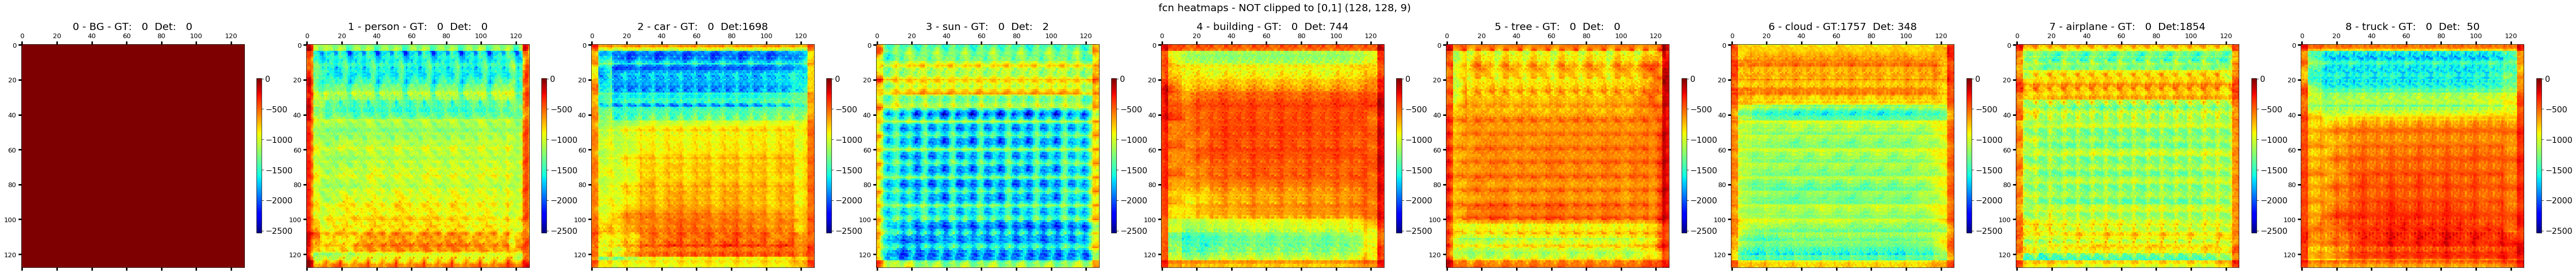

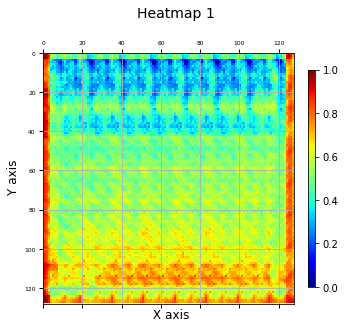

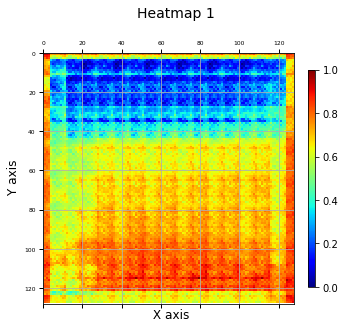

In [106]:
print(load_file)
vis2.display_fcn_agg_heatmaps(fcn_agg_hm, gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', title = 'fcn heatmaps - NOT clipped to [0,1]')
vis.plot_2d_gaussian(vis2.normalize_fcn_hm(fcn_agg_hm[:,:,1]), size =(5,5))
vis.plot_2d_gaussian(vis2.normalize_fcn_hm(fcn_agg_hm[:,:,2]), size =(5,5))

In [ ]:
vis2.display_fcn_agg_heatmaps_3d(fcn_agg_hm, gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns =7, title = 'fcn heatmaps - NOT clipped to [0,1]')

In [ ]:
vis2.display_fcn_input_1(fcn_agg_hm, gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns =7, title = 'fcn heatmaps - NOT clipped to [0,1]')
vis.plot_2d_gaussian(vis2.normalize_fcn_hm(fcn_agg_hm[:,:,1]), size =(5,5))
vis.plot_2d_gaussian(vis2.normalize_fcn_hm(fcn_agg_hm[:,:,2]), size =(5,5))

In [ ]:
vis2.display_fcn_input_1(fcn_agg_hm, gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns =7, title = 'fcn heatmaps - NOT clipped to [0,1]')
vis.plot_2d_gaussian(vis2.normalize_fcn_hm(fcn_agg_hm[:,:,1]), size =(5,5))
vis.plot_2d_gaussian(vis2.normalize_fcn_hm(fcn_agg_hm[:,:,2]), size =(5,5))

### fcn normalized

In [ ]:
vis2.display_fcn_input_1(vis2.normalize_fcn_hm(fcn_agg_hm), gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns = 7, title = 'fcn heatmaps - NOT clipped to [0,1],  Normalized -')

### fcn clipped

In [ ]:
vis2.display_fcn_input_1(fcn_agg_hm_clipped, gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns = 7, title = 'fcn heatmaps - clipped to [0,1] - ')

### fcn clipped - normalized

In [ ]:
# vis2.display_fcn_input_1(vis2.deprocess_image(fcn_agg_hm_clipped), gt_cls_counts, dt_cls_counts, class_names, cmap = 'jet', columns = 7, title = 'fcn heatmaps - clipped to [0 ,1] and Normalized - ')

##  3D Plots

####  3D plot of  `gt_heatmap_norm` returned form code above

In [ ]:
print('Image : {}  ClassIds: {}'.format(img_id, gt_class_ids))
visualize.plot_3d_heatmap(model_gt_heatmap, img_id, gt_class_ids, class_names = coco_class_names, scaling='class')

####  3D plot of `pred_heatmap_norm` returned form model

In [ ]:
print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
visualize.plot_3d_heatmap(model_pr_heatmap, img_id, pr_class_ids, class_names = coco_class_names, zlim = 'class' , scaling = 'none')

####  3D plot of `fcn_heatmap` returned form model - only classes in pred_scores

In [ ]:
print(np.max(model_fcn_heatmap), np.min(model_fcn_heatmap))

print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
visualize.plot_3d_heatmap(model_fcn_heatmap, img_id, pr_class_ids,class_names = coco_class_names, scaling = 'none')

####  3D plot of `fcn_heatmap` returned form model - all classes

In [ ]:
print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
#     plot_3d_heatmap(model_fcn_heatmap, img_id, class_ids,class_names = class_names, size = (8,8), zlim=0)
visualize.plot_3d_heatmap(model_fcn_heatmap, img_id, class_names = coco_class_names, columns = 3,scaling = 'all')

####  3D comparative display `pred_heatmap` / `fcn_heatmap` 

In [ ]:
print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
visualize.plot_3d_heatmap_compare(model_pr_heatmap, model_fcn_heatmap, img_id, class_ids = pr_class_ids, 
                            class_names = coco_class_names, size=(8,8), zlim = 'all' , scaling = 'all')

####  3D comparative display `gt_heatmap` / `fcn_heatmap` 

In [ ]:
print('Image : {}  ClassIds: {}'.format(img_id, gt_class_ids))
visualize.plot_3d_heatmap_compare(model_gt_heatmap, model_fcn_heatmap, img_id, gt_class_ids, class_names = coco_class_names, scaling = 'none')